# Wonderful Wines of the World

## Initial Setup

In [1]:
## import libraries

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

import os
from math import ceil



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm


import umap
import umap.plot


In [3]:
from sklearn.base import clone

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA, FactorAnalysis

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PowerTransformer, RobustScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth


from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score, silhouette_samples

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

import graphviz


In [4]:
import warnings
warnings.filterwarnings('ignore')

# https://stackoverflow.com/questions/56618739/matplotlib-throws-warning-message-because-of-findfont-python
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# importing sompy enables more logging
logging.disable(logging.INFO)

In [5]:
#!pip install kneed

In [6]:
from kneed import KneeLocator

In [7]:
## Note versions used

print('Pandas version ',pd.__version__)
print('Numpy version ',np.__version__)
print('Scipy version ',sp.__version__)
print('Seaborn version ',sns.__version__)


Pandas version  1.3.3
Numpy version  1.20.3
Scipy version  1.7.0
Seaborn version  0.11.2


## Define some constant variables

In [8]:
COLORS = ['#7a2b5d', '#975c86', '#b38dad', '#d0bed6', '#edf0ff', '#eae1cd', '#e8d19a', '#e6c064', '#e3ae29']
CAT_COLORS = ['#7a2b5d', '#4475B0', '#21BFAB', '#EBBD53', '#EF5072']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = COLORS.copy()

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
CAT_PALETTE = sns.color_palette(CAT_COLORS)

sns.set_palette(DEFAULT_PALETTE)

DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True
RANDOM_STATE = 0

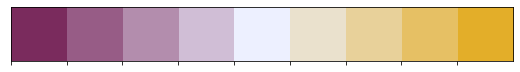

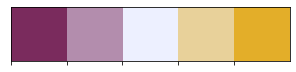

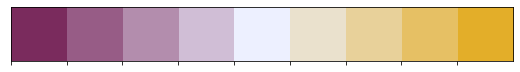

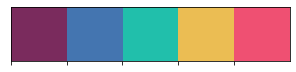

In [9]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

In [10]:
sns.set_context("paper")
sns.set(style="white")

plt.rcParams['figure.dpi'] = 70

In [11]:
show_plots = True
img_counter = 0
random_state = 0

IMG_PATH = '../../out/imgs/'

## Define some functions

In [12]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight')
        


In [13]:
## Function to plot histograms of numeric features for specified dataframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if SHOW_PLOTS:
        cols = ceil(len(features) / rows)
        fig = plt.figure(figsize=(4*cols,4*rows),
                         constrained_layout=True)
        
        subfigs = fig.subfigures(rows, cols)
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(2, 1, sharex=True, \
                                gridspec_kw={'height_ratios': [4,1]})
        
            axs[0].hist(df[feat], color=COLORS[0])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1, fontsize=6*rows)
        
            axs[1].set_xlabel(None)
            flierprops = dict(markerfacecolor='None', markersize=6,  markeredgecolor=COLORS[0])
            sns.boxplot(x=df[feat], ax=axs[1], color=COLORS[0], flierprops=flierprops)
            axs[1].set_xlabel(None)

            subf.suptitle(None)
        
        plt.suptitle(title, fontsize=8*rows)
        if SAVE_PLOTS:
            save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")

In [14]:
def getIQR(df, colname) :
    q25 = df[colname].quantile(.25)
    q75 = df[colname].quantile(.75)
    iqr = (q75 - q25)

    upper_lim = q75 + 2 * iqr
    lower_lim = q25 - 2 * iqr

    above_ul = df.loc[df[colname]>upper_lim]
    below_ll = df.loc[df[colname]<lower_lim]
    
    if len(above_ul) > 0 :
        print(str(len(above_ul)) + " or " + str(round((100*len(above_ul)/len(df)),4)) + "% of rows are above the UL ["+ colname + "].")
    if len(below_ll) > 0 :
        print(str(len(below_ll)) + " or " + str(round((100*len(below_ll)/len(df)),4)) + "% of rows are below the LL ["+ colname + "].")

    
    return upper_lim, lower_lim, len(above_ul), len(below_ll)




## Load Dataset

In [15]:
df = pd.read_excel('../data/WonderfulWinesoftheWorld.xlsx')
df_original = df.copy(deep=True)

## Remove last row
df.drop(df.tail(1).index,inplace=True)
df['Custid'] = df['Custid'].astype(int)
df.set_index('Custid', inplace=True)

df.head(3)

Dayswus   Age   Edu    Income  Freq  Recency  Monetary    LTV  \
Custid                                                                  
5325      653.0  55.0  20.0   78473.0  20.0     18.0     826.0  445.0   
3956     1041.0  75.0  18.0  105087.0  36.0     33.0    1852.0  539.0   
3681      666.0  18.0  12.0   27984.0   4.0     56.0      39.0   -7.0   

        Perdeal  Dryred  Sweetred  Drywh  Sweetwh  Dessert  Exotic  \
Custid                                                               
5325        7.0    67.0       4.0   26.0      2.0      1.0     1.0   
3956        2.0    49.0       0.0   46.0      1.0      3.0     0.0   
3681       88.0     4.0      29.0   14.0     32.0     21.0    48.0   

        WebPurchase  WebVisit  
Custid                         
5325           36.0       5.0  
3956           20.0       4.0  
3681           60.0       8.0

In [16]:
df.describe().to_csv('../../out/data/data_summary.csv')

## Data Understanding

### Check datatypes

In [17]:
df.dtypes

Dayswus        float64
Age            float64
Edu            float64
Income         float64
Freq           float64
Recency        float64
Monetary       float64
LTV            float64
Perdeal        float64
Dryred         float64
Sweetred       float64
Drywh          float64
Sweetwh        float64
Dessert        float64
Exotic         float64
WebPurchase    float64
WebVisit       float64
dtype: object

All variables are numeric.

### Check for duplicates

In [18]:
print(df[df.duplicated(keep=False)])

Empty DataFrame
Columns: [Dayswus, Age, Edu, Income, Freq, Recency, Monetary, LTV, Perdeal, Dryred, Sweetred, Drywh, Sweetwh, Dessert, Exotic, WebPurchase, WebVisit]
Index: []


### Identify features for segmentation

In [19]:
## Wine preference features
wine_features = ['Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert', 'Exotic']

## Value segmentation features
value_features = ['Dayswus', 'Freq', 'Recency', 'Monetary', 'LTV', 'Perdeal']

## Separate Demographic features for cluster descriptions later
demog_features = ['Age', 'Edu', 'Income']

## Separate other features
other_features = ['WebPurchase', 'WebVisit']


### Distributions of values for variables

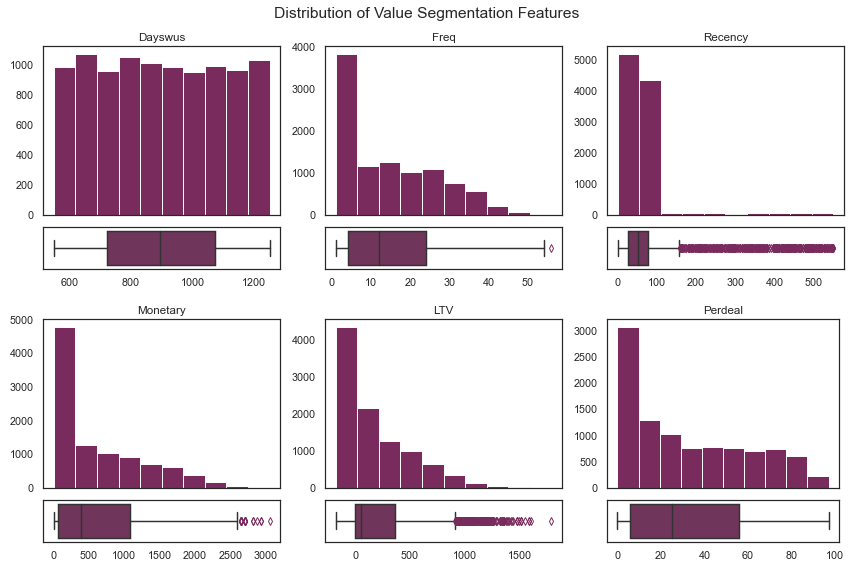

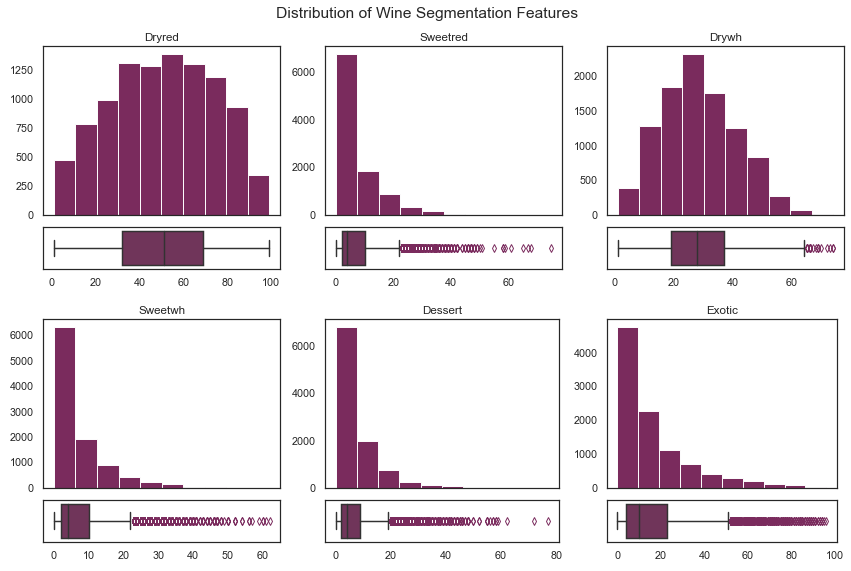

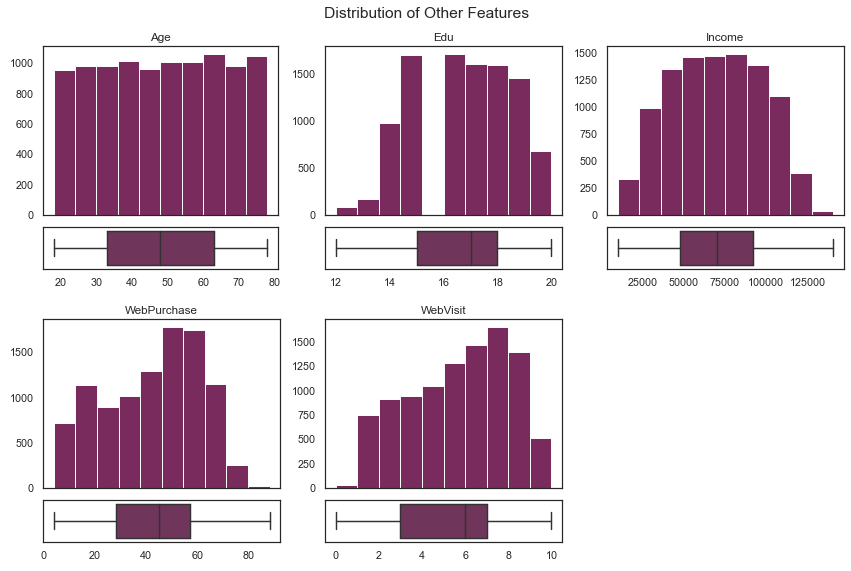

In [20]:
plot_histograms_boxplots(df, value_features, rows=2, title='Distribution of Value Segmentation Features')
plot_histograms_boxplots(df, wine_features, rows=2, title='Distribution of Wine Segmentation Features')
plot_histograms_boxplots(df, (demog_features+other_features), rows=2, title='Distribution of Other Features')

## Data Preparation

### Check for correlation

In [21]:
def make_corr_heatmap(df, method, title="Triangle Correlation Heatmap"):
    l = len(df.columns.tolist())
    fig = plt.figure(figsize=(2*l, 1.5*l))
    mask = np.triu(np.ones_like(df.corr(method=method), dtype=bool))
    heatmap = sns.heatmap(df.corr(method=method), mask=mask, vmin=-1, vmax=1, annot=True, fmt='.2f' ,cmap=DIV_CMAP)
    heatmap.set_title(title, fontdict={'fontsize':18}, pad=2);
    save_fig(title, fig)
    plt.show()

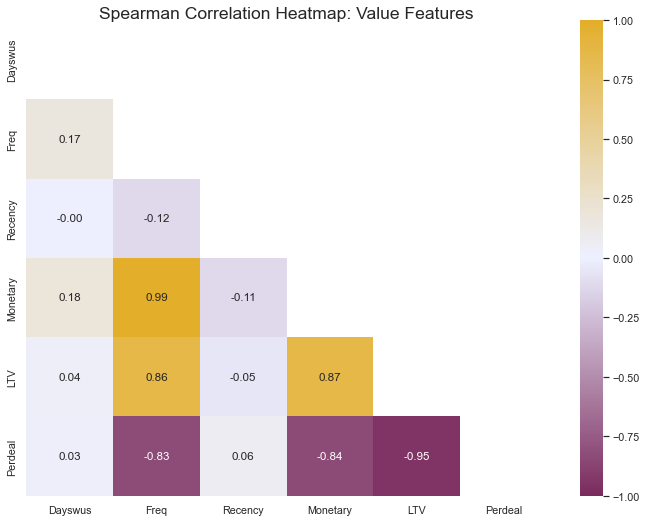

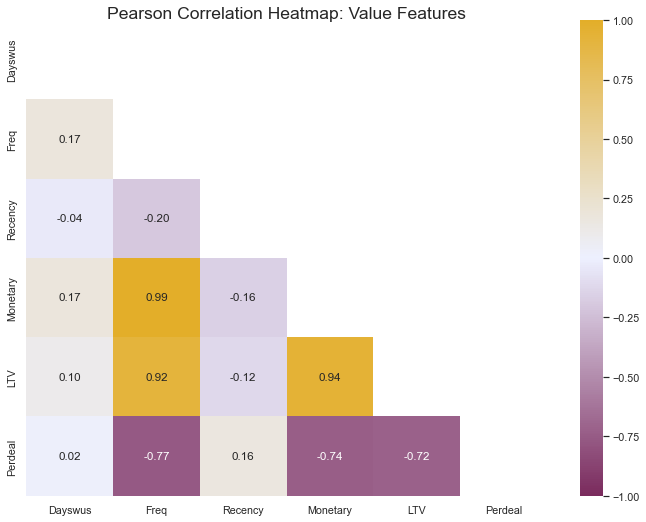

In [22]:
make_corr_heatmap(df[value_features], 'spearman', title="Spearman Correlation Heatmap: Value Features")
make_corr_heatmap(df[value_features], 'pearson', title="Pearson Correlation Heatmap: Value Features")


In [23]:
## Remove Perdeal because highly correlated with multiple feats
value_features.remove('Perdeal')
other_features.append('Perdeal')

## Remove Monetary because highly correlated with Freq, LTV
value_features.remove('Monetary')
other_features.append('Monetary')


## Remove Frequency and LTV because highly correlated with Monetary
value_features2 = ['Dayswus', 'Recency', 'Monetary']

value_features

['Dayswus', 'Freq', 'Recency', 'LTV']

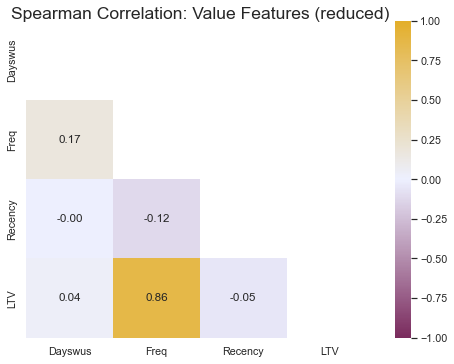

In [24]:
make_corr_heatmap(df[value_features], 'spearman', title="Spearman Correlation: Value Features (reduced)")


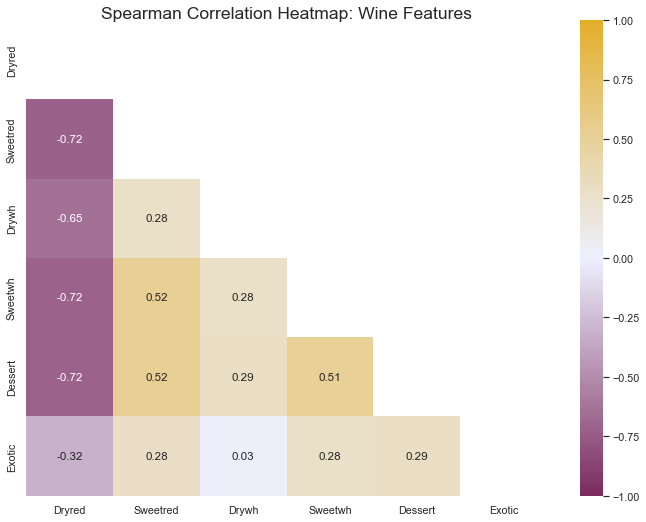

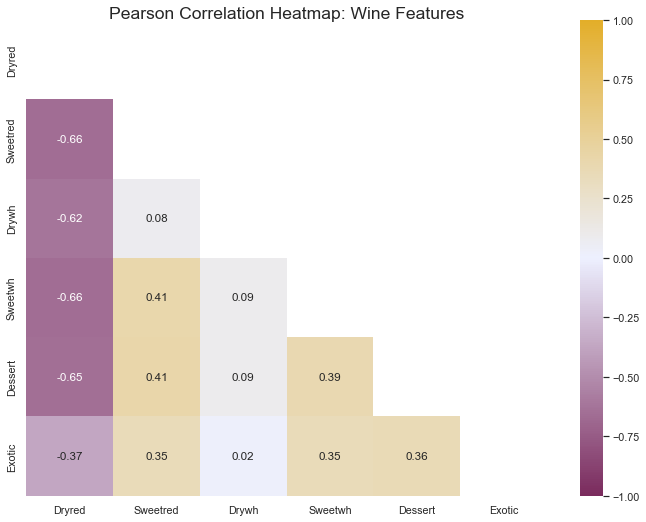

In [25]:
make_corr_heatmap(df[wine_features], 'spearman', title="Spearman Correlation Heatmap: Wine Features")
make_corr_heatmap(df[wine_features], 'pearson', title="Pearson Correlation Heatmap: Wine Features")


### Check for outliers

In [26]:
for v in df.columns.tolist():
    getIQR(df, v)

363 or 3.63% of rows are above the UL [Recency].
117 or 1.17% of rows are above the UL [LTV].
358 or 3.58% of rows are above the UL [Sweetred].
2 or 0.02% of rows are above the UL [Drywh].
365 or 3.65% of rows are above the UL [Sweetwh].
474 or 4.74% of rows are above the UL [Dessert].
331 or 3.31% of rows are above the UL [Exotic].


Too many outliers to remove just based on IQR

In [27]:
df['Outlier'] = 0

In [28]:
df.loc[df['Dessert']>70,['Outlier']] = 1
df.loc[df['Sweetred']>70,['Outlier']] = 1

In [29]:
df.loc[df['Freq']>55,['Outlier']] = 1
df.loc[df['LTV']>1750,['Outlier']] = 1

In [30]:
df_hasoutliers = df.copy()

In [31]:
df = df[df['Outlier']==0]

In [32]:
df_outliers = df[df['Outlier']==1]

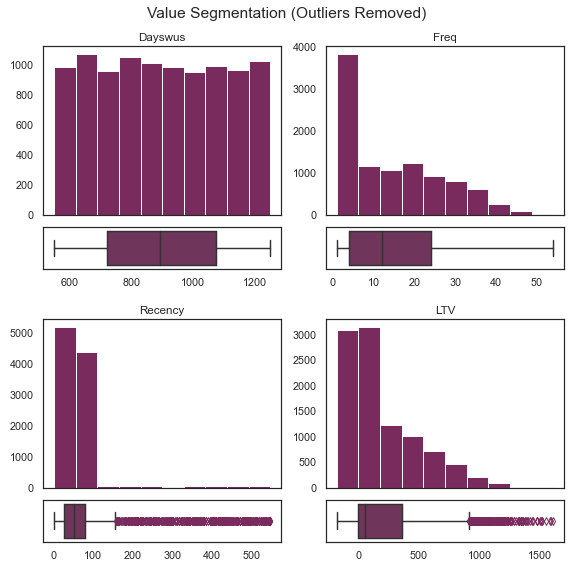

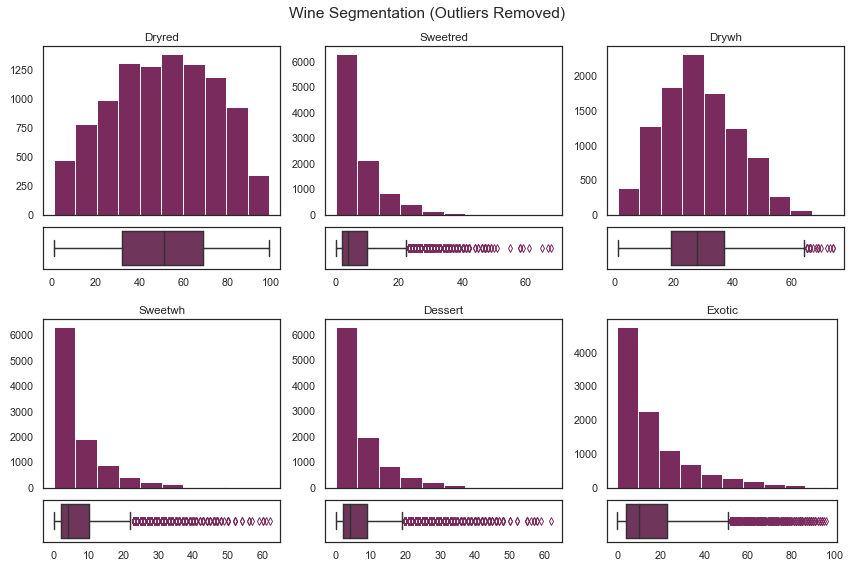

In [33]:
plot_histograms_boxplots(df, value_features, rows=2, title='Value Segmentation (Outliers Removed)')
plot_histograms_boxplots(df, wine_features, rows=2, title='Wine Segmentation (Outliers Removed)')

## Transform Variables

### MinMax Scaler

We only scale the Value Segmentation Features because the Wine Segmentation Features are all in the same scale (percentage) already.

In [34]:
mmscaler = MinMaxScaler()

value_feats_mm = value_features.copy()

for fi in range(len(value_feats_mm)):
    t = value_feats_mm[fi] + '_mm'
    value_feats_mm[fi] = t
    df[t] = df[value_features[fi]]

df[value_feats_mm] = mmscaler.fit_transform(df[value_feats_mm])


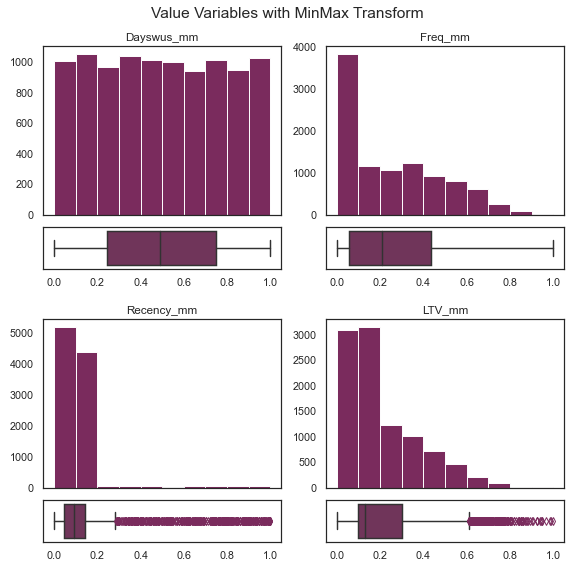

In [35]:
plot_histograms_boxplots(df, value_feats_mm, rows=2, title='Value Variables with MinMax Transform')


### Transform wine features to decimal (from percentage)

In [36]:
wine_feats_dec = wine_features.copy()

for fi in range(len(wine_feats_dec)):
    t = wine_feats_dec[fi] + '_dec'
    wine_feats_dec[fi] = t
    df[t] = df[wine_features[fi]]/100


## Use DBSCAN to identify 'noise' rows

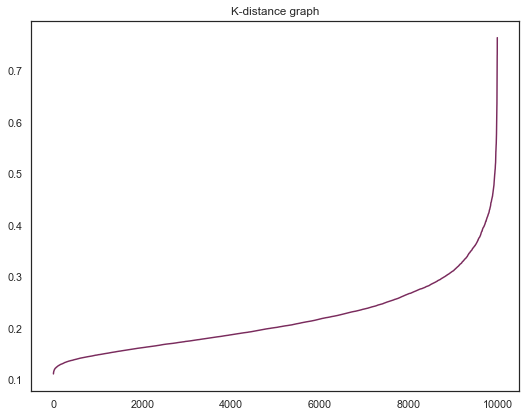

In [37]:
vars_ = wine_feats_dec + value_feats_mm
neigh = NearestNeighbors(n_neighbors=50)
neigh.fit(df[vars_])
distances, _ = neigh.kneighbors(df[vars_])
distances = np.sort(distances[:, -1])

fig, axis = plt.subplots(figsize=(9,7))
plt.plot(distances, color=COLORS[0])
plt.title('K-distance graph')
plt.show()

save_fig('K-distance graph', fig)

In [38]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=.35, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[vars_])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


In [39]:
# Concatenating the labels to df
df_dbscan = pd.concat([df[vars_], pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
df_dbscan.groupby(['dbscan_labels']).count()

Dryred_dec  Sweetred_dec  Drywh_dec  Sweetwh_dec  Dessert_dec  \
dbscan_labels                                                                  
-1                     30            30         30           30           30   
 0                   9966          9966       9966         9966         9966   

               Exotic_dec  Dayswus_mm  Freq_mm  Recency_mm  LTV_mm  
dbscan_labels                                                       
-1                     30          30       30          30      30  
 0                   9966        9966     9966        9966    9966

In [40]:
df_ = pd.concat([df, pd.Series(dbscan_labels, index=df.index, name="Noise")], axis=1)
df_noise = df_.loc[df_['Noise'] == -1]
df = df_.loc[df_['Noise'] != -1]
df_nonoise = df_.loc[df_['Noise'] != -1]


In [41]:
df.drop(columns=['Noise'], inplace=True)
df

Dayswus   Age   Edu    Income  Freq  Recency  Monetary    LTV  \
Custid                                                                  
5325      653.0  55.0  20.0   78473.0  20.0     18.0     826.0  445.0   
3956     1041.0  75.0  18.0  105087.0  36.0     33.0    1852.0  539.0   
3681      666.0  18.0  12.0   27984.0   4.0     56.0      39.0   -7.0   
2829     1049.0  42.0  16.0   61748.0   2.0     46.0      37.0   -6.0   
8788      837.0  47.0  16.0   65789.0   2.0      3.0      36.0    4.0   
...         ...   ...   ...       ...   ...      ...       ...    ...   
1383     1132.0  57.0  20.0   81033.0  19.0     59.0     776.0  187.0   
4070      596.0  66.0  15.0   84714.0  18.0     45.0     720.0  391.0   
7909      619.0  18.0  12.0   40466.0   3.0     65.0      47.0    5.0   
4158     1107.0  33.0  16.0   53661.0   1.0    368.0      15.0    2.0   
4914      979.0  55.0  16.0   94926.0  25.0     28.0    1148.0  293.0   

        Perdeal  Dryred  ...  Dayswus_mm   Freq_mm  Recency_mm    LTV_mm  \
Custid                   ...                                               
5325        7.0    67.0  ...    0.147143  0.358491    0.032787  0.348824   
3956        2.0    49.0  ...    0.701429  0.660377    0.060109  0.401456   
3681       88.0     4.0  ...    0.165714  0.056604    0.102004  0.095745   
2829       70.0    86.0  ...    0.712857  0.018868    0.083789  0.096305   
8788       35.0    85.0  ...    0.410000  0.018868    0.005464  0.101904   
...         ...     ...  ...         ...       ...         ...       ...   
1383       22.0    78.0  ...    0.831429  0.339623    0.107468  0.204367   
4070        5.0    30.0  ...    0.065714  0.320755    0.081967  0.318589   
7909       23.0     6.0  ...    0.098571  0.037736    0.118397  0.102464   
4158       35.0    18.0  ...    0.795714  0.000000    0.670310  0.100784   
4914        7.0    63.0  ...    0.612857  0.452830    0.051002  0.263718   

        Dryred_dec  Sweetred_dec  Drywh_dec  Sweetwh_dec  Dessert_dec  \
Custid                                                                  
5325          0.67          0.04       0.26         0.02         0.01   
3956          0.49          0.00       0.46         0.01         0.03   
3681          0.04          0.29       0.14         0.32         0.21   
2829          0.86          0.01       0.11         0.01         0.01   
8788          0.85          0.00       0.12         0.02         0.01   
...            ...           ...        ...          ...          ...   
1383          0.78          0.00       0.20         0.01         0.01   
4070          0.30          0.12       0.36         0.10         0.12   
7909          0.06          0.24       0.10         0.38         0.22   
4158          0.18          0.13       0.45         0.11         0.13   
4914          0.63          0.10       0.13         0.11         0.03   

        Exotic_dec  
Custid              
5325          0.01  
3956          0.00  
3681          0.48  
2829          0.55  
8788          0.28  
...            ...  
1383          0.11  
4070          0.13  
7909          0.41  
4158          0.13  
4914          0.04  

[9966 rows x 28 columns]

In [42]:
print('Percentage of rows considered noise:')
100*len(df_dbscan.loc[df_dbscan['dbscan_labels'] == -1])/len(df)

Percentage of rows considered noise:


0.30102347983142685

## Summary of Variables

In [43]:
## Original value features
print(value_features)
df[value_features].head(3)

['Dayswus', 'Freq', 'Recency', 'LTV']


Dayswus  Freq  Recency    LTV
Custid                               
5325      653.0  20.0     18.0  445.0
3956     1041.0  36.0     33.0  539.0
3681      666.0   4.0     56.0   -7.0

In [44]:
## Original wine features
print(wine_features)
df[wine_features].head(3)

['Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert', 'Exotic']


Dryred  Sweetred  Drywh  Sweetwh  Dessert  Exotic
Custid                                                   
5325      67.0       4.0   26.0      2.0      1.0     1.0
3956      49.0       0.0   46.0      1.0      3.0     0.0
3681       4.0      29.0   14.0     32.0     21.0    48.0

In [45]:
## MinMax transformed value features
print(value_feats_mm)
df[value_feats_mm].head(3)

['Dayswus_mm', 'Freq_mm', 'Recency_mm', 'LTV_mm']


Dayswus_mm   Freq_mm  Recency_mm    LTV_mm
Custid                                            
5325      0.147143  0.358491    0.032787  0.348824
3956      0.701429  0.660377    0.060109  0.401456
3681      0.165714  0.056604    0.102004  0.095745

In [46]:
## Decimal wine features
print(wine_feats_dec)
df[wine_feats_dec].head(3)

['Dryred_dec', 'Sweetred_dec', 'Drywh_dec', 'Sweetwh_dec', 'Dessert_dec', 'Exotic_dec']


Dryred_dec  Sweetred_dec  Drywh_dec  Sweetwh_dec  Dessert_dec  \
Custid                                                                  
5325          0.67          0.04       0.26         0.02         0.01   
3956          0.49          0.00       0.46         0.01         0.03   
3681          0.04          0.29       0.14         0.32         0.21   

        Exotic_dec  
Custid              
5325          0.01  
3956          0.00  
3681          0.48

# Clustering

## Some helpful functions

In [47]:
## Code from Lab #13

def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2_(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst

def r2(dft, df, labels, feats):
    sst = get_ss(dft[feats])
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst

def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2_(df, labels)
    return r2_clust


def showR2Plot(r2_scores, title=""):
    # Visualizing the R² scores for each cluster solution on demographic variables
    fig, ax = plt.subplots(figsize=(10,7))
    pd.DataFrame(r2_scores).plot(ax=ax)
    plt.title("R² Plot: " + title)
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("R² metric")
    save_fig('R2_Plot_'+ title, fig)
    plt.show()


In [48]:
def show_cluster_heatmap(df, label1, cols, title='Heatmap of Cluster Means'):
    fig, ax = plt.subplots(constrained_layout=True , figsize=(len(cols)*1.4,len(cols)*.8), sharey=True)
    
    label_counts = df.groupby(label1)[label1].count()
    
    xticks = [(str(l) + "\n" + str(label_counts[l])) for l in range(len(label_counts))]
    
    sns.heatmap(df.groupby(label1)[cols].mean().loc[range(0,len(label_counts)),:].T, \
            vmin=0, vmax=1,
            cmap=DIV_CMAP, xticklabels=xticks, annot=True, fmt='.2f', annot_kws={"fontsize":14})

    k = len(df[label1].unique().tolist())
    
    ax.set_xlabel(('Cluster Sizes and Labels, K = '+str(k)))
    fig.suptitle(title, y=1.1, fontsize=20)
    
    if SAVE_PLOTS:
        save_fig(title, fig)
    
    plt.show()


In [49]:
def compare_cluster_heatmap(df, k1, k2, label1, label2, cols, title='Heatmap of Cluster Means'):
    fig, ax = plt.subplots(1,2,gridspec_kw={'width_ratios': [k1, k2]} ,\
                           constrained_layout=True , figsize=(14,len(cols)*.8), sharey=True)
    
    label_counts = df.groupby(label1)[label1].count()
    
    xticks = [(str(l) + "\n" + str(label_counts[l])) for l in range(len(label_counts))]
    sns.heatmap(df.groupby(label1)[cols].mean().loc[range(0,k1),:].T, \
            vmin=0, vmax=1,\
            cmap=DIV_CMAP, ax=ax[0], xticklabels=xticks, annot=True, fmt='.2f', annot_kws={"fontsize":16})

    label_counts = df.groupby(label2)[label2].count()
    
    xticks = [(str(l) + "\n" + str(label_counts[l])) for l in range(len(label_counts))]
    sns.heatmap(df.groupby(label2)[cols].mean().loc[range(0,k2),:].T, \
            vmin=0, vmax=1,\
            cmap=DIV_CMAP, ax=ax[1], xticklabels=xticks, annot=True, fmt='.2f', annot_kws={"fontsize":16})

    ax[0].set_xlabel('Cluster Sizes and Labels, K='+str(k1))
    ax[1].set_xlabel('Cluster Sizes and Labels, K='+str(k2))
    fig.suptitle(title, y=1.1, fontsize=20)
    save_fig(title, fig)
    
    plt.show()


In [50]:
def show_elbow_silhouette(df, features, max_k=40):
    n_clusters = range(2,max_k)
    silhouette_scores = []
    sum_squared_dist = []
    r_scores = []
    
    for num_clusters in n_clusters:
        kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=1500,n_init=100,random_state=RANDOM_STATE)
        
        kmeans.fit(df[features])
        cluster_labels = kmeans.labels_
        sum_squared_dist.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(df[features], cluster_labels,\
                                                  metric='euclidean', \
                                                  sample_size=None, random_state=None))
        df['labels'] = cluster_labels
        r_scores.append(r2_(df, 'labels'))
    
    fig, ax1 = plt.subplots(figsize=(11,7))
    ax2 = ax1.twinx()

    ax1.plot(n_clusters,sum_squared_dist, color=CAT_COLORS[0], label='Inertia')

    #ax2.plot(n_clusters, r_scores, color=CAT_COLORS[2], label='R2' )
    
    ax1.set_xlabel('Values of K')
    ax1.set_ylabel('Inertia', color=COLORS[0])
    
    #ax2.set_ylabel('R2 Score', color=CAT_COLORS[2])
    #ax2.yaxis.set_label_coords(.97, 0.5)
    
    kl = KneeLocator(range(1, len(sum_squared_dist)+1), sum_squared_dist, curve="convex", direction="decreasing")
    ax1.axvline(x=kl.elbow, label='Elbow', color=CAT_COLORS[0], linestyle='dashed')
    
    fig.legend(loc="center right", bbox_to_anchor=(.85, .5))
    plt.xticks(range(1,max_k+1,2))
    plt.title('Inertia Plot')
    save_fig('Inertia R2 Plot', fig)
    
    

    plt.show()

    print('Knee located at k=', kl.elbow)
    


In [51]:
def plot_clusters(df, labels, title='Cluster Visualization'):    
    
    fig, ax = plt.subplots(figsize=(10,10))

    scatter = ax.scatter(x=df[0], y=df[1], c=labels, cmap=CAT_CMAP,\
               s=2, marker="o", alpha=.9, label='Final Clusters')

    ncol = len(labels.unique().tolist())
    ncol = round(ncol/2) + 1 if ncol > 7 else ncol
    legend1 = ax.legend(*scatter.legend_elements(),
                        bbox_to_anchor=(.5,1,.5,1), loc="lower left", frameon=False,
                        mode='expand', borderaxespad=0, ncol=ncol)

    ax.set_xticklabels('')
    ax.set_yticklabels('')
    plt.title(title, loc='left')
    
    if SAVE_PLOTS:
        save_fig(title, fig)

    plt.show()


In [52]:
## Code based from Lab 09
def plot_dendrogram(model, title, **kwargs):
    sns.set_palette(CAT_PALETTE)

    # Create linkage matrix and then plot the dendrogram
    
    fig, ax = plt.subplots(figsize=(11,5))
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
    plt.hlines(kwargs['color_threshold'], 0, 1000, colors="r", linestyles="dashed")
    
    
    plt.xticks(rotation=90)
    plt.title(title)

    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    save_fig(title, fig)
    plt.show()
    
    sns.set_palette(DEFAULT_PALETTE)
    


In [53]:
## Scoring
r_scores_wine = pd.DataFrame(columns=['method','r2','clusters'])
r_scores_value = pd.DataFrame(columns=['method','r2','clusters'])


## Wine Segmentation

In [54]:
df_wine_kmeans = df_nonoise[wine_feats_dec].copy() 

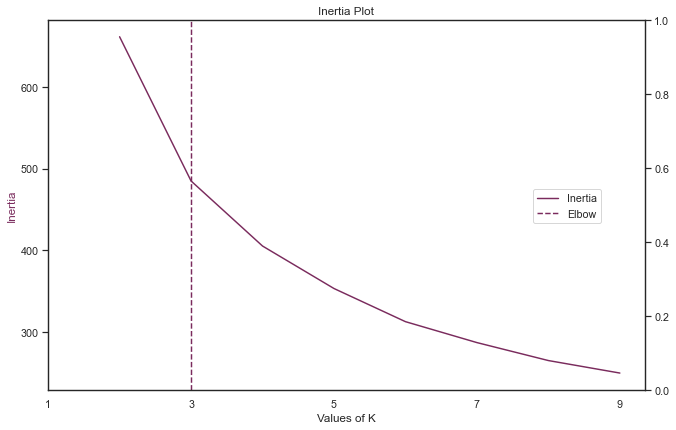

Knee located at k= 3


In [55]:
show_elbow_silhouette(df_wine_kmeans, wine_feats_dec, max_k=10)

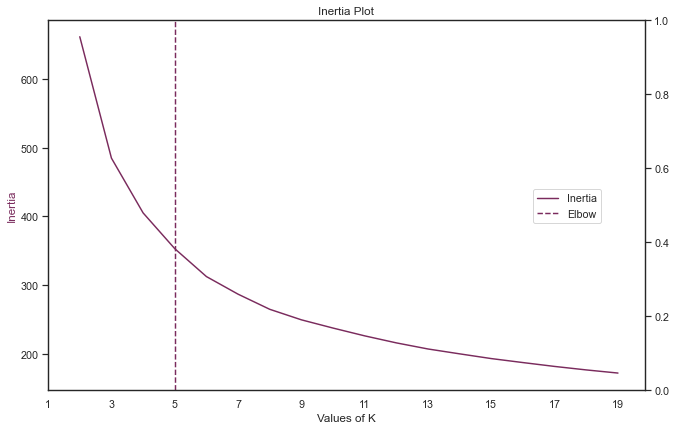

Knee located at k= 5


In [56]:
show_elbow_silhouette(df_wine_kmeans, wine_feats_dec, max_k=20)

In [57]:
df_wk = df_wine_kmeans.copy()

for k in range(2,10):
    wine_kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=30, random_state=RANDOM_STATE)
    wine_k_labels = wine_kmeans.fit_predict(df_wk)

    df_wk['wine_'+str(k)] = wine_k_labels
    r2_(df_wk[wine_feats_dec+['wine_'+str(k)]],'wine_'+str(k))

    r_append = {
        'method': 'kmeans',
        'r2': r2_(df_wk[wine_feats_dec+['wine_'+str(k)]],'wine_'+str(k)),
        'clusters':k
    }
    r_scores_wine = r_scores_wine.append(r_append, ignore_index=True)




### Compare cluster means of different K

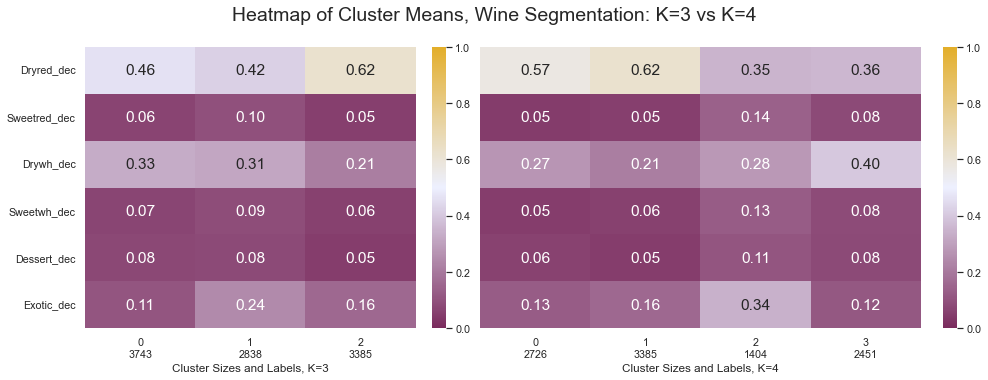

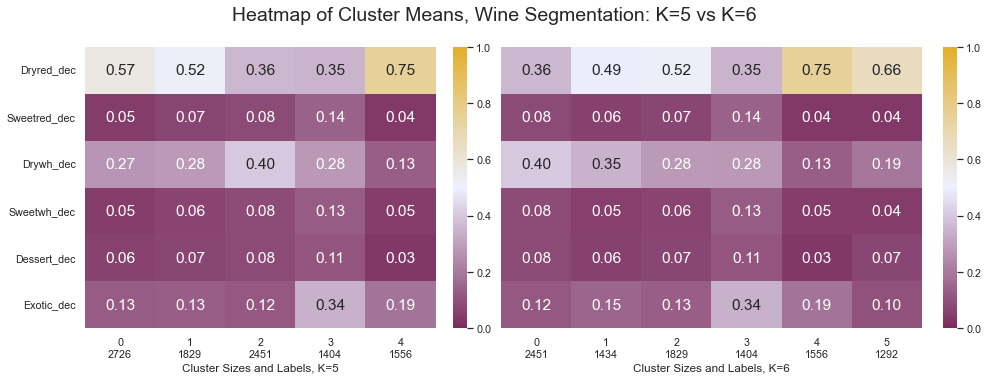

In [58]:
compare_cluster_heatmap(df_wk, 3, 4, 'wine_3', 'wine_4', wine_feats_dec, 'Heatmap of Cluster Means, Wine Segmentation: K=3 vs K=4')

compare_cluster_heatmap(df_wk, 5, 6, 'wine_5', 'wine_6', wine_feats_dec, 'Heatmap of Cluster Means, Wine Segmentation: K=5 vs K=6')



### Characterize final wine segmentation clusters

In [59]:
r_scores_wine

method        r2 clusters
0  kmeans  0.683548        2
1  kmeans  0.874791        3
2  kmeans  0.934504        4
3  kmeans  0.959820        5
4  kmeans  0.974525        6
5  kmeans  0.977185        7
6  kmeans  0.983696        8
7  kmeans  0.989675        9

In [60]:
r_scores_wine.to_csv('../../out/data/r_scores_wine.csv')

In [61]:
wine_k = 3
wine_kmeans = KMeans(n_clusters=wine_k, init='k-means++', max_iter=1000000, n_init=30, random_state=RANDOM_STATE)
wine_k_labels = wine_kmeans.fit_predict(df_wine_kmeans)

df_wine_kmeans['wine_labels'] = wine_k_labels
r2_(df_wine_kmeans,'wine_labels')


0.8874841433586386

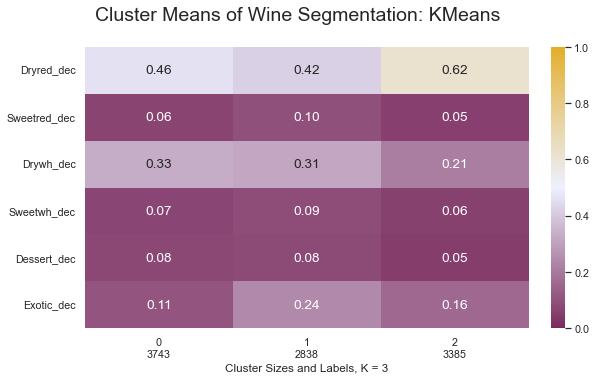

In [62]:
show_cluster_heatmap(df_wine_kmeans, 'wine_labels', wine_feats_dec, 'Cluster Means of Wine Segmentation: KMeans')


### Visualize wine segmentation clusters

In [63]:
wine_tsne = TSNE(random_state=RANDOM_STATE).fit_transform(df_wine_kmeans[wine_feats_dec])

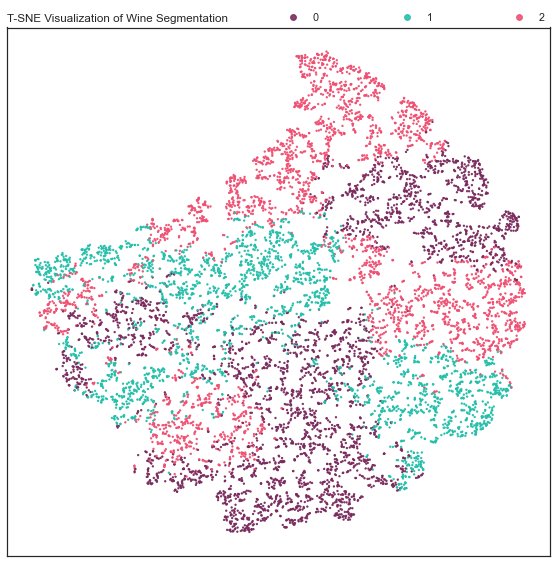

In [64]:
tsne_wine_df = pd.DataFrame(wine_tsne)
plot_clusters(tsne_wine_df, df_wine_kmeans['wine_labels'], 'T-SNE Visualization of Wine Segmentation')

In [65]:
wine_umap = umap.UMAP(random_state=RANDOM_STATE, metric='euclidean', min_dist=1, n_neighbors=150, n_components=2)\
                    .fit_transform(df_wine_kmeans[wine_feats_dec])
umap_wine_df = pd.DataFrame(wine_umap)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


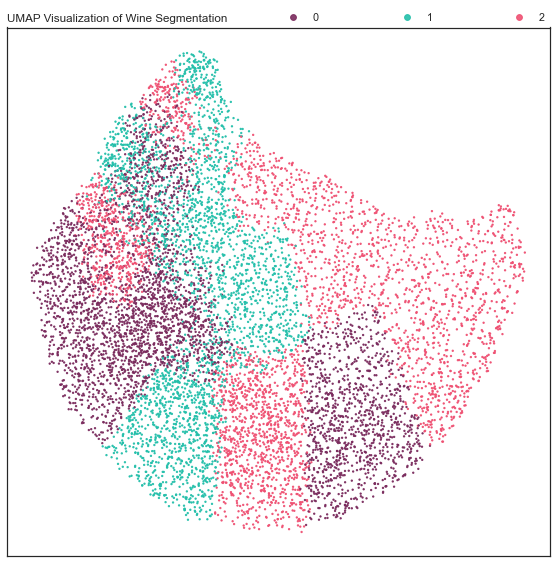

In [66]:
plot_clusters(umap_wine_df, df_wine_kmeans['wine_labels'], 'UMAP Visualization of Wine Segmentation')

## Value Segmentation

In [67]:
df_value_kmeans = df[value_feats_mm].copy()
df_value_hclust = df[value_feats_mm].copy()

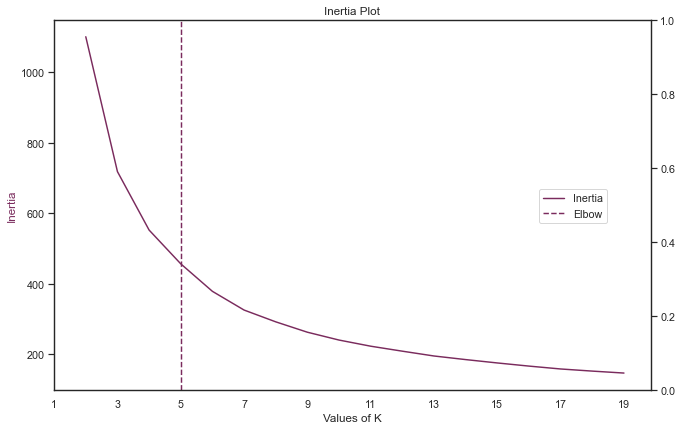

Knee located at k= 5


In [68]:
show_elbow_silhouette(df_value_kmeans, value_feats_mm, max_k=20)

In [69]:
value_k = 4
value_kmeans = KMeans(n_clusters=value_k, init='k-means++', n_init=100, random_state=RANDOM_STATE)
value_k_labels = value_kmeans.fit_predict(df_value_kmeans)
df_value_kmeans['value_labels'] = value_k_labels


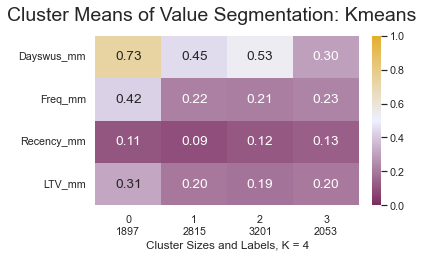

In [70]:
show_cluster_heatmap(df_value_kmeans, 'value_labels', value_feats_mm, 'Cluster Means of Value Segmentation: Kmeans')

In [71]:
r2_(df_value_kmeans,'value_labels')

0.9471518221989301

In [72]:
linkage = 'ward'
distance = 'euclidean'
value_hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=value_k)
value_labels = value_hclust.fit_predict(df_value_hclust)

df_value_hclust['value_labels'] = value_labels


In [73]:
df_vh = df_value_kmeans.copy()

for k in range(2,10):
    value_hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=k)
    value_h_labels = value_hclust.fit_predict(df_vh)

    df_vh['value_'+str(k)] = value_h_labels

    r_append = {
        'method': 'hclust',
        'r2': r2_(df_vh[value_feats_mm+['value_'+str(k)]],'value_'+str(k)),
        'clusters':k
    }
    r_scores_value = r_scores_value.append(r_append, ignore_index=True)


#r_scores_value

In [74]:
df_vk = df_value_kmeans.copy()

for k in range(2,10):
    value_kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=30, random_state=RANDOM_STATE)
    value_k_labels = value_kmeans.fit_predict(df_vk)

    df_vk['value_'+str(k)] = value_k_labels

    r_append = {
        'method': 'kmeans',
        'r2': r2_(df_vk[value_feats_mm+['value_'+str(k)]],'value_'+str(k)),
        'clusters':k
    }
    r_scores_value = r_scores_value.append(r_append, ignore_index=True)


#r_scores_value

### Characterize value segmentation clusters

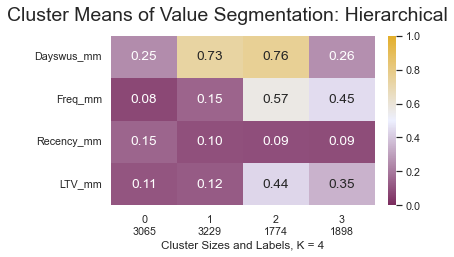

In [75]:
show_cluster_heatmap(df_value_hclust, 'value_labels', value_feats_mm, 'Cluster Means of Value Segmentation: Hierarchical')

### Visualize Value Segmentation

In [76]:
value_tsne = TSNE(random_state=RANDOM_STATE).fit_transform(df_value_kmeans[value_feats_mm])

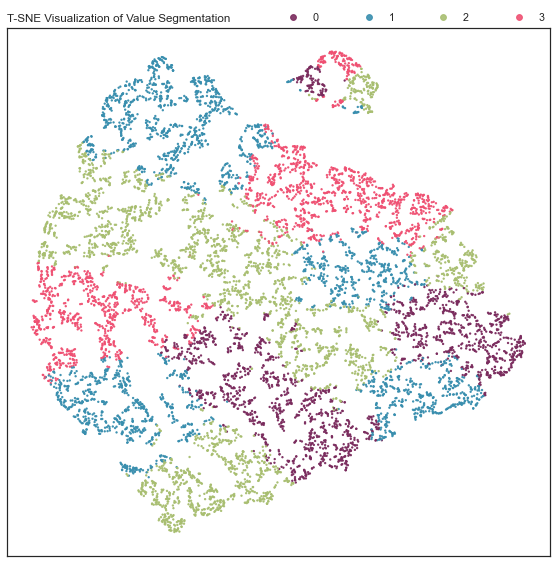

In [77]:
tsne_value_df = pd.DataFrame(value_tsne)
plot_clusters(tsne_value_df, df_value_kmeans['value_labels'], 'T-SNE Visualization of Value Segmentation')

In [78]:
value_umap = umap.UMAP(random_state=RANDOM_STATE, metric='euclidean', min_dist=1, n_neighbors=150, n_components=2)\
                    .fit_transform(df_value_kmeans[value_feats_mm])
umap_value_df = pd.DataFrame(value_umap)

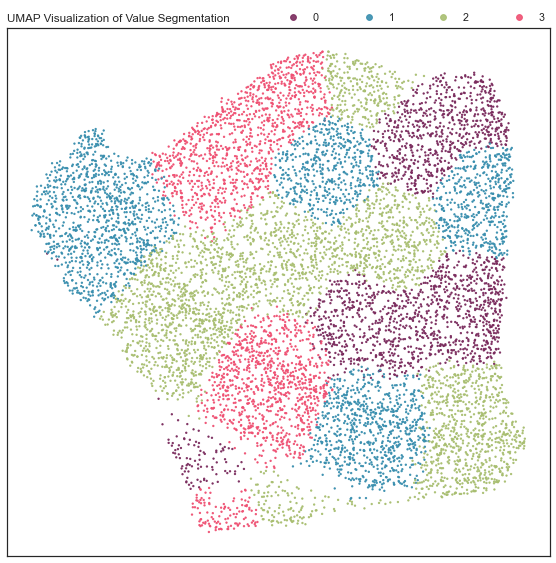

In [79]:
plot_clusters(umap_value_df, df_value_kmeans['value_labels'], 'UMAP Visualization of Value Segmentation')


## Merging cluster solutions

In [80]:
df_merged = df_value_kmeans.copy()
df_merged = df_merged.merge(df_wine_kmeans, left_index=True, right_index=True )

In [81]:
df_merged.to_csv('../../out/data/mergedclusters.csv')

In [82]:
df_merged.groupby(['value_labels', 'wine_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('value_labels', 'wine_labels', 0).fillna('-')



wine_labels      0    1     2
value_labels                 
0              748  435   714
1             1027  845   943
2             1151  963  1087
3              817  595   641

In [83]:
vw_feats = value_feats_mm+wine_feats_dec
df_centroids = df_merged.groupby(['value_labels', 'wine_labels'])[vw_feats].mean()

In [84]:
merged_hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_merged_labels = merged_hclust.fit_predict(df_centroids)

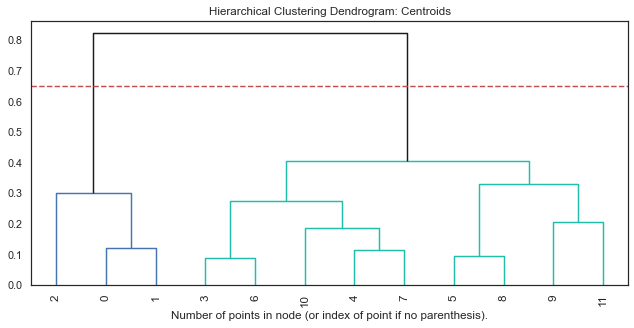

In [85]:
plot_dendrogram(merged_hclust, title='Hierarchical Clustering Dendrogram: Centroids',\
                truncate_mode="level", p=15, \
                above_threshold_color='k', color_threshold=.65)

In [86]:
final_k = 6
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust_final = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=final_k
    
)

hclust_labels_final = hclust_final.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels_final

#df_centroids

In [87]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
#print(cluster_mapper)
df_ = df_merged.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['value_labels'], row['wine_labels'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()[vw_feats]

Dayswus_mm   Freq_mm  Recency_mm    LTV_mm  Dryred_dec  \
merged_labels                                                           
0                0.279262  0.245658    0.130405  0.211299    0.524143   
1                0.462946  0.177051    0.115877  0.173321    0.408269   
2                0.717851  0.446690    0.113174  0.343084    0.481826   
3                0.488431  0.222985    0.104059  0.188768    0.606995   
4                0.744710  0.380926    0.107348  0.264724    0.682759   
5                0.488094  0.244105    0.102605  0.210714    0.458283   

               Sweetred_dec  Drywh_dec  Sweetwh_dec  Dessert_dec  Exotic_dec  
merged_labels                                                                 
0                  0.061063   0.282305     0.066241     0.065995    0.123909  
1                  0.101548   0.312231     0.092580     0.085227    0.258269  
2                  0.065520   0.324573     0.063762     0.064269    0.116517  
3                  0.057951   0.218931     0.061384     0.054286    0.170576  
4                  0.040728   0.195602     0.040490     0.039888    0.132185  
5                  0.065101   0.327847     0.069945     0.078682    0.117709

In [88]:
df_.groupby('merged_labels').count()[vw_feats]

Dayswus_mm  Freq_mm  Recency_mm  LTV_mm  Dryred_dec  \
merged_labels                                                        
0                    1458     1458        1458    1458        1458   
1                    2403     2403        2403    2403        2403   
2                    1183     1183        1183    1183        1183   
3                    2030     2030        2030    2030        2030   
4                     714      714         714     714         714   
5                    2178     2178        2178    2178        2178   

               Sweetred_dec  Drywh_dec  Sweetwh_dec  Dessert_dec  Exotic_dec  
merged_labels                                                                 
0                      1458       1458         1458         1458        1458  
1                      2403       2403         2403         2403        2403  
2                      1183       1183         1183         1183        1183  
3                      2030       2030         2030         2030        2030  
4                       714        714          714          714         714  
5                      2178       2178         2178         2178        2178

### Visualizing merged cluster solution

In [89]:
merged_tsne = TSNE(random_state=RANDOM_STATE).fit_transform(df_[vw_feats])

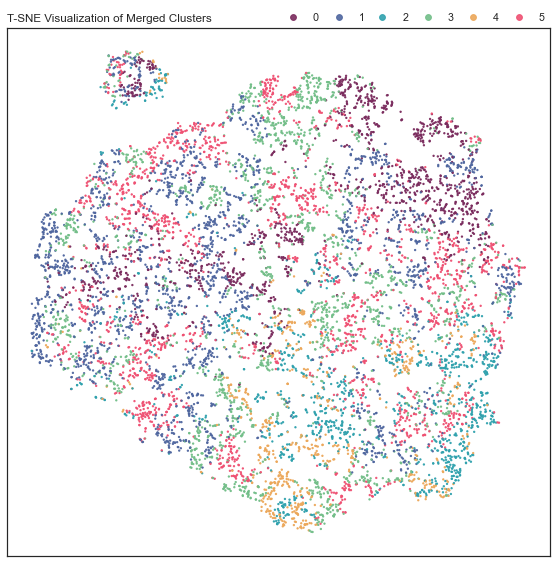

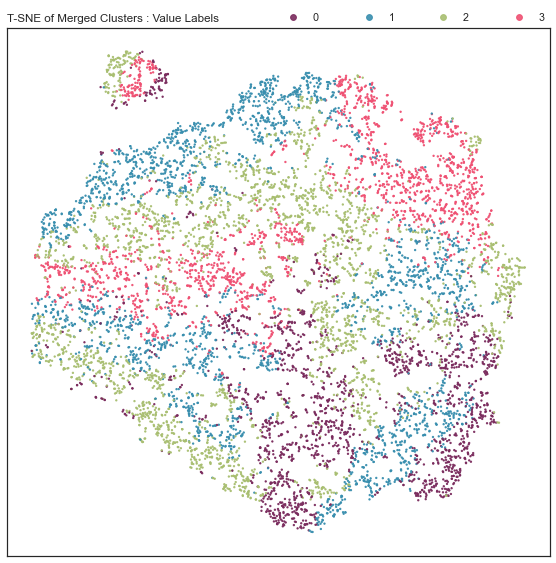

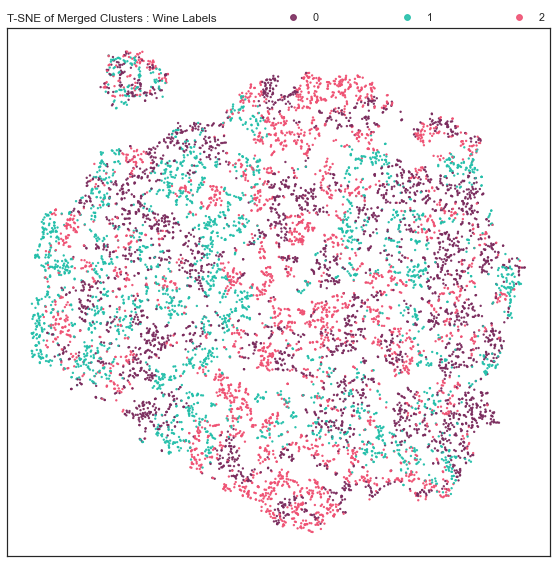

In [90]:
tsne_merged_df = pd.DataFrame(merged_tsne)
plot_clusters(tsne_merged_df, df_['merged_labels'], 'T-SNE Visualization of Merged Clusters')
plot_clusters(tsne_merged_df, df_['value_labels'], 'T-SNE of Merged Clusters : Value Labels')
plot_clusters(tsne_merged_df, df_['wine_labels'], 'T-SNE of Merged Clusters : Wine Labels')

In [91]:
merged_umap = umap.UMAP(random_state=RANDOM_STATE, metric='euclidean', min_dist=1, n_neighbors=150, n_components=2)\
                    .fit_transform(df_[vw_feats])
umap_merged_df = pd.DataFrame(merged_umap)


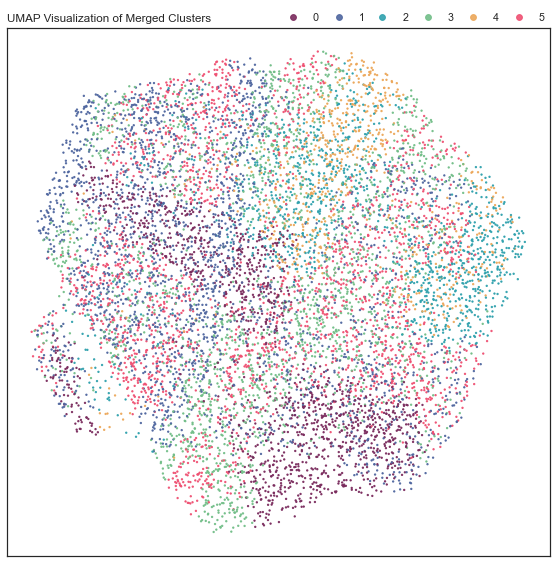

In [92]:
plot_clusters(umap_merged_df, df_['merged_labels'], 'UMAP Visualization of Merged Clusters')


In [93]:
#plot_clusters(umap_merged_df, df_['wine_labels'], 'UMAP of Merged Clusters: Wine Labels')
#plot_clusters(umap_merged_df, df_['value_labels'], 'UMAP of Merged Clusters: Value Labels')


# Characterizing final clusters

In [94]:
## Function to plot histograms of numeric features for specified dataframe
def plot_final_histo_box(df, features, col, title = "Final Clusters: Relative Distributions of Numeric Variables"):
    if show_plots:
        
        rows = sorted(df[col].unique().tolist())
    
        cols = range(len(features))

        fig = plt.figure(figsize=(22,28), \
                         constrained_layout=True)
        
        
        
        subfigs = fig.subfigures(len(rows), len(features), facecolor='#fdfdfd')
        for c in cols: # feats
            for r in rows: # clusters
                color = cm.viridis(float(r) / len(rows))
                
                
                df_ = df.loc[df[col]==r,[features[c]]]
                axs = subfigs[r][c].subplots(2, 1, sharex=True, \
                                gridspec_kw={'height_ratios': [4,1]})
                axs[0].hist(df_, color=color)
                axs[0].set_xlim(0,1)
                axs[0].set_title(features[c], y=1, fontsize=20)
                
                sns.boxplot(x=df_[features[c]], ax=axs[1], color=color)
                axs[1].set_xlabel(None)
                
                if c==0:
                    csize = ' [ ' + str(len(df_)) + ' ]'
                    axs[0].set_ylabel('Cluster '+ str(r)+csize)
        
        plt.suptitle(title, fontsize=24)
        if SAVE_PLOTS:
            save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")
        


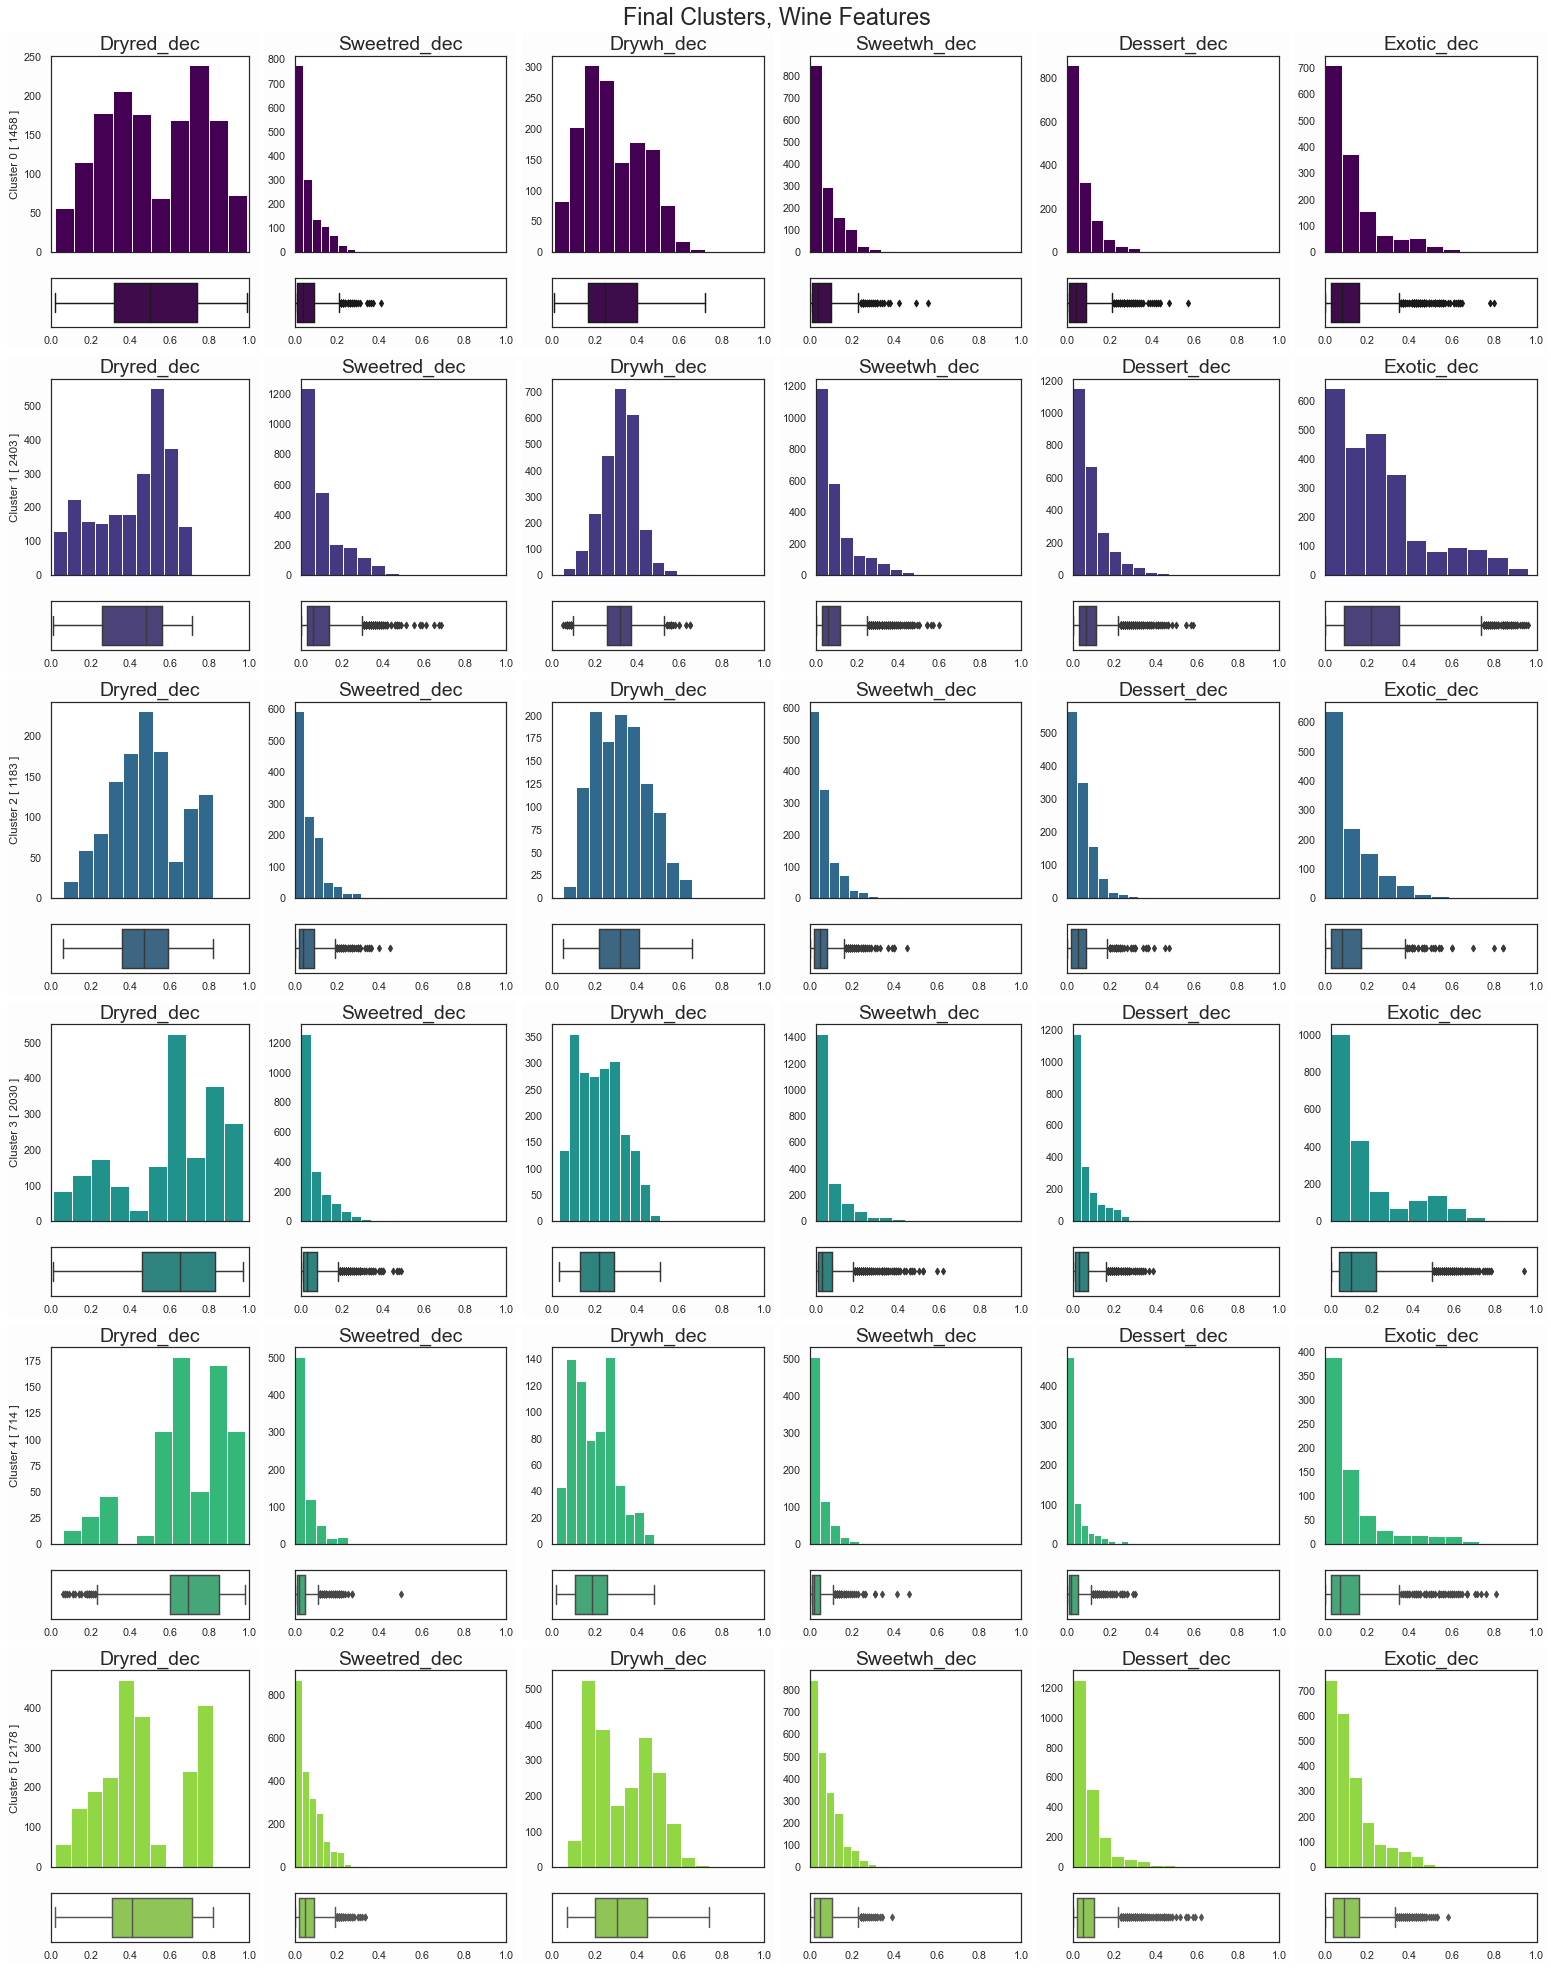

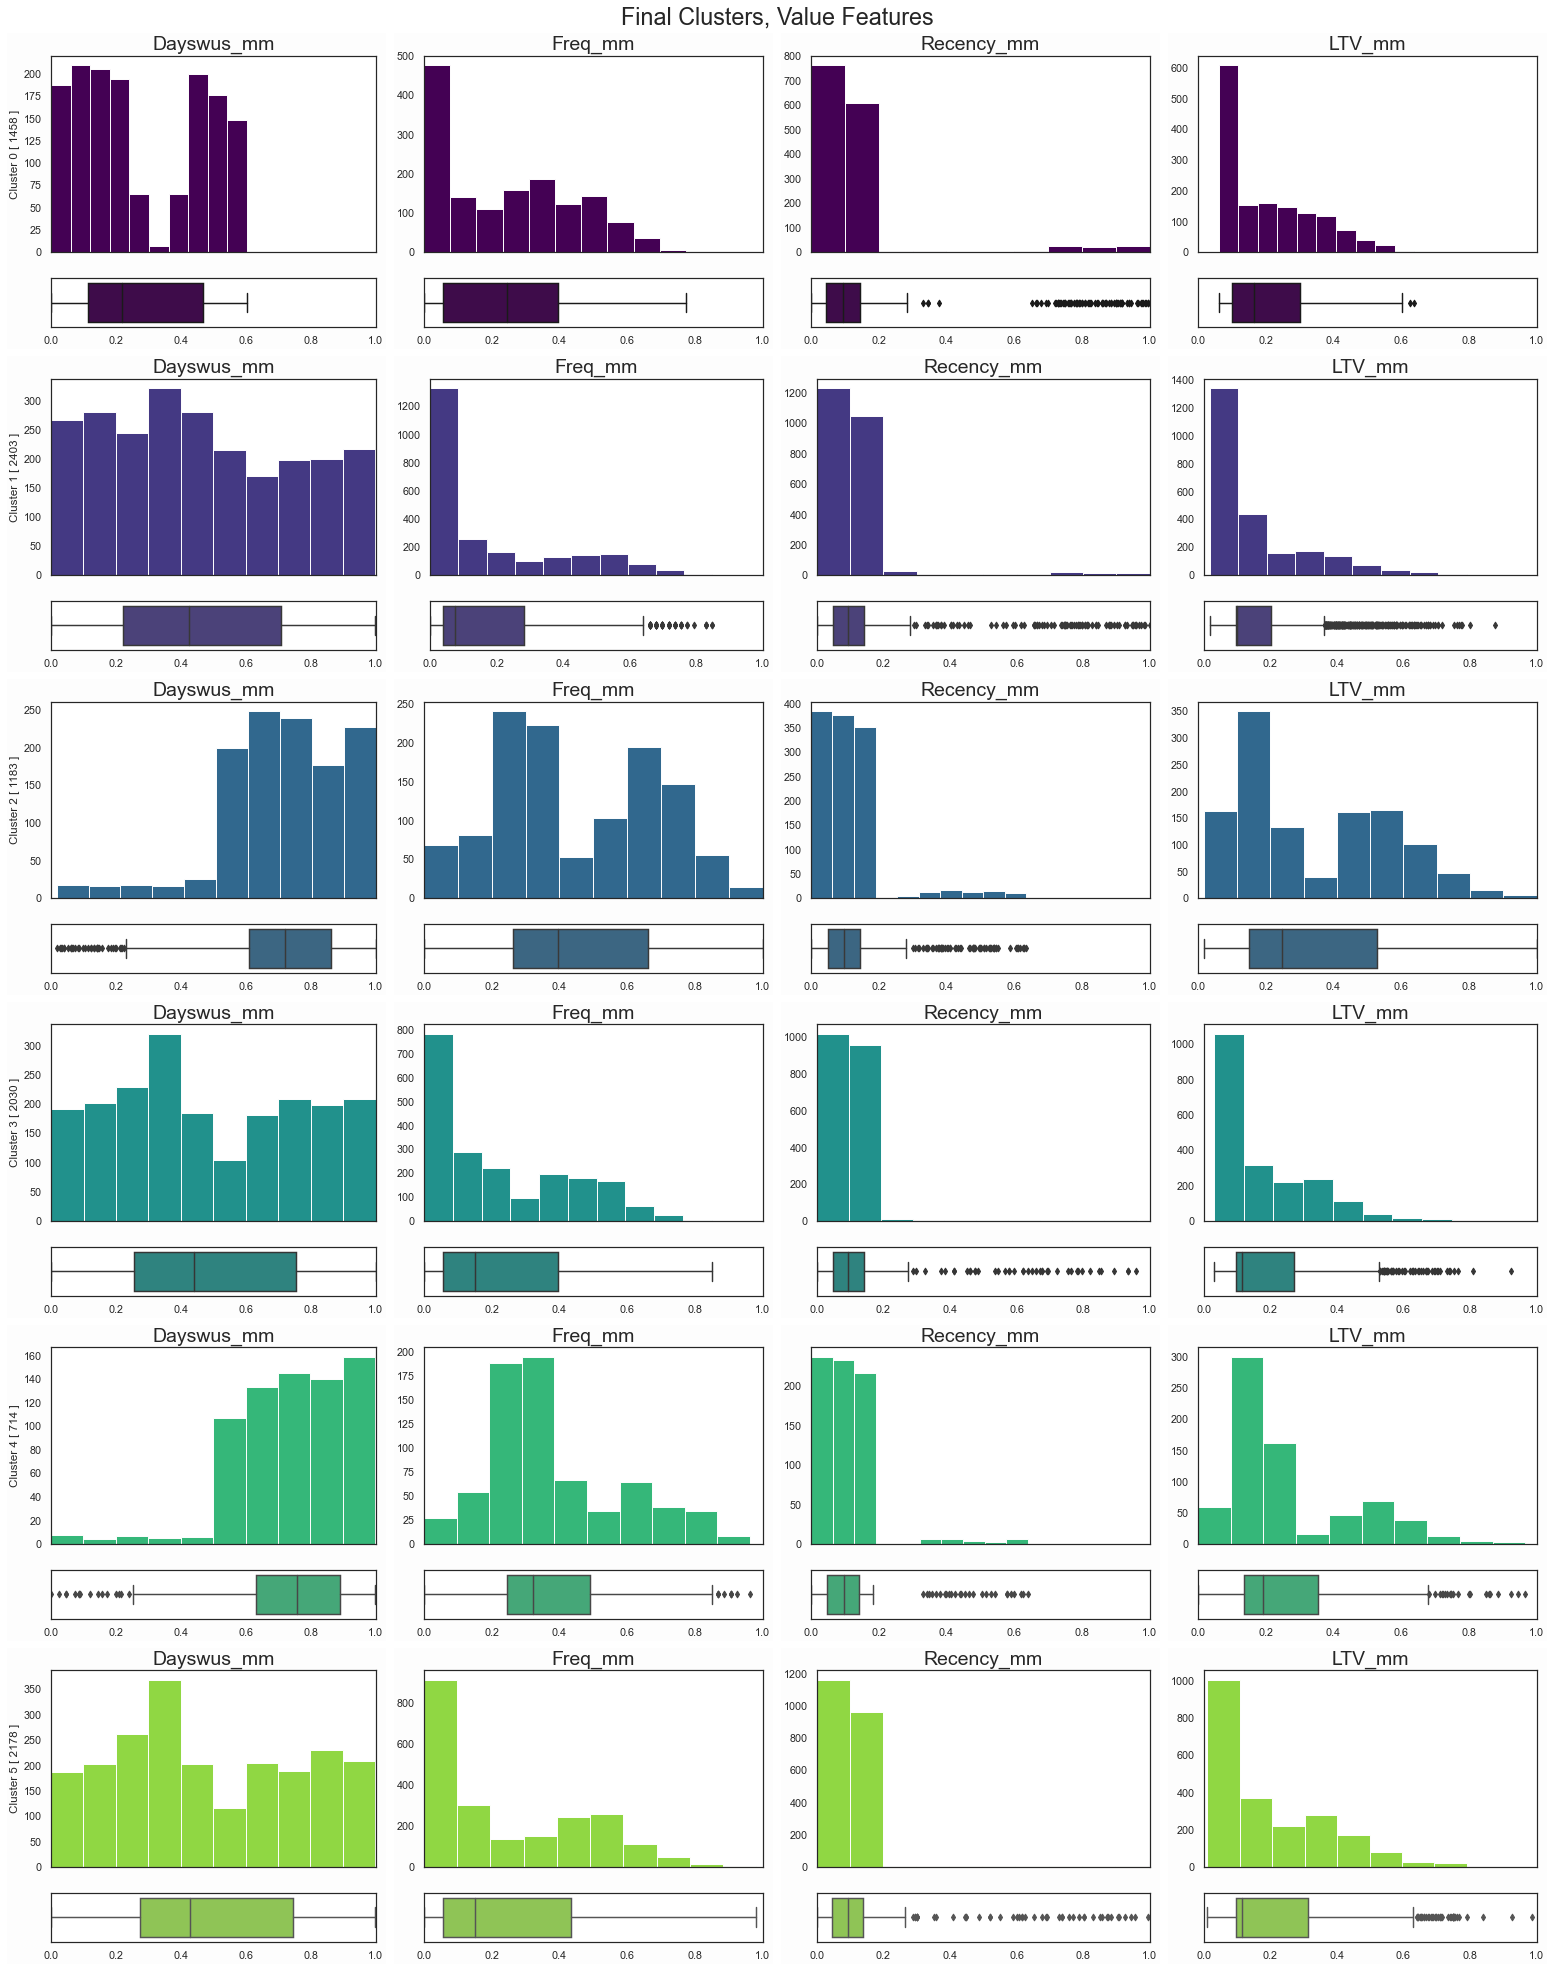

In [95]:
plot_final_histo_box(df_, wine_feats_dec, 'merged_labels', title='Final Clusters, Wine Features')
plot_final_histo_box(df_, value_feats_mm, 'merged_labels', title='Final Clusters, Value Features')

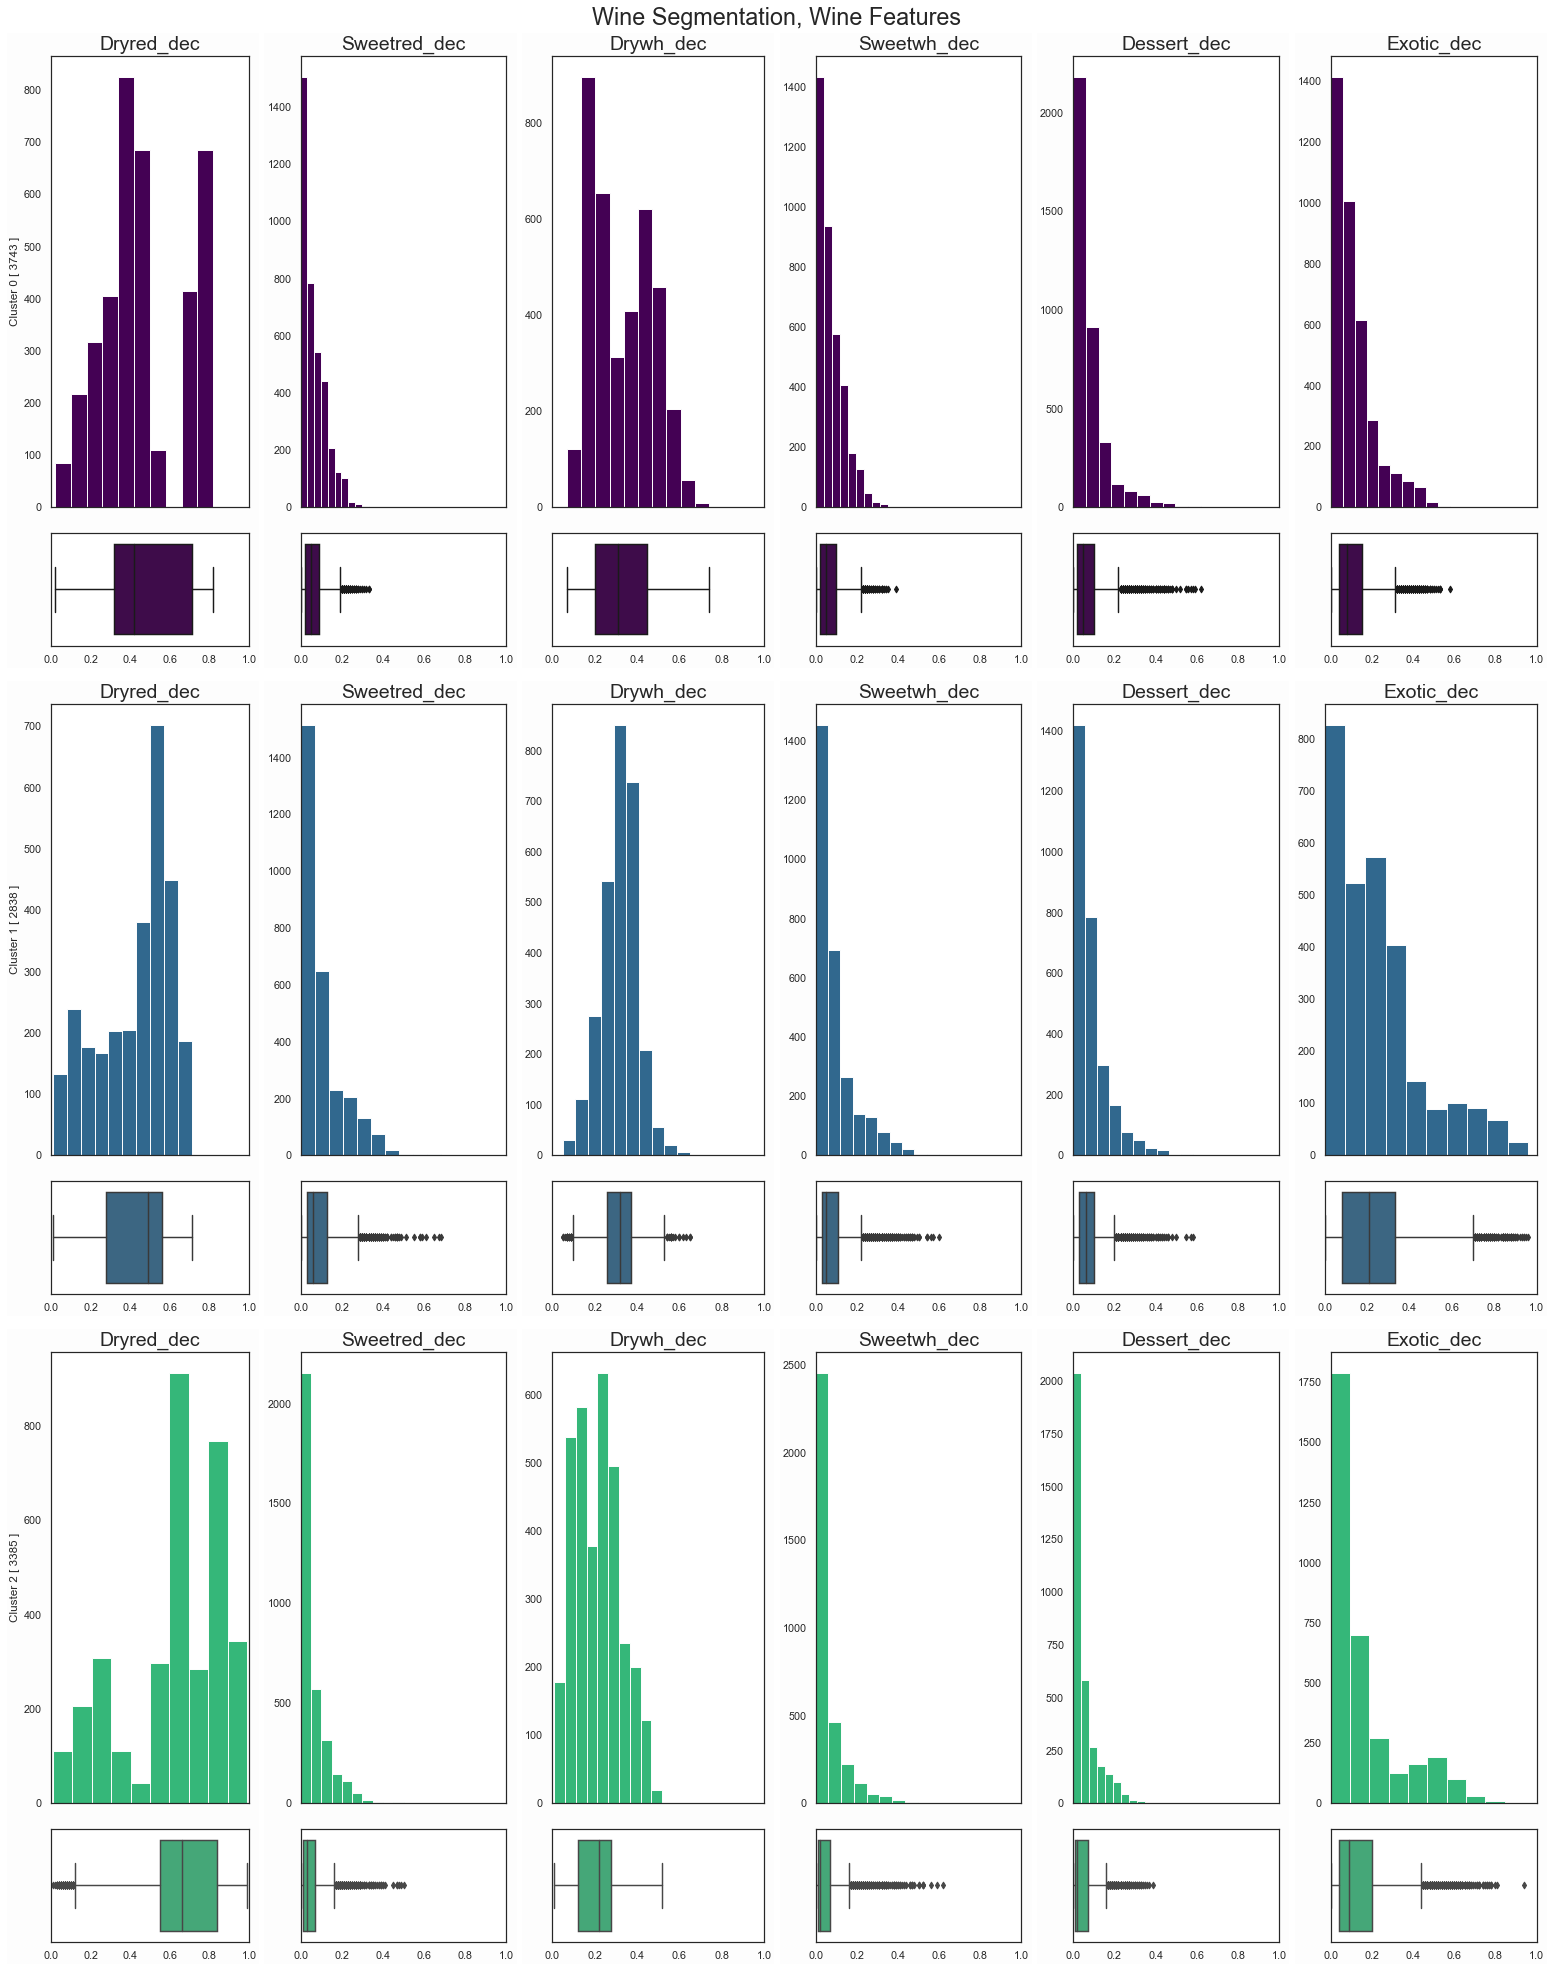

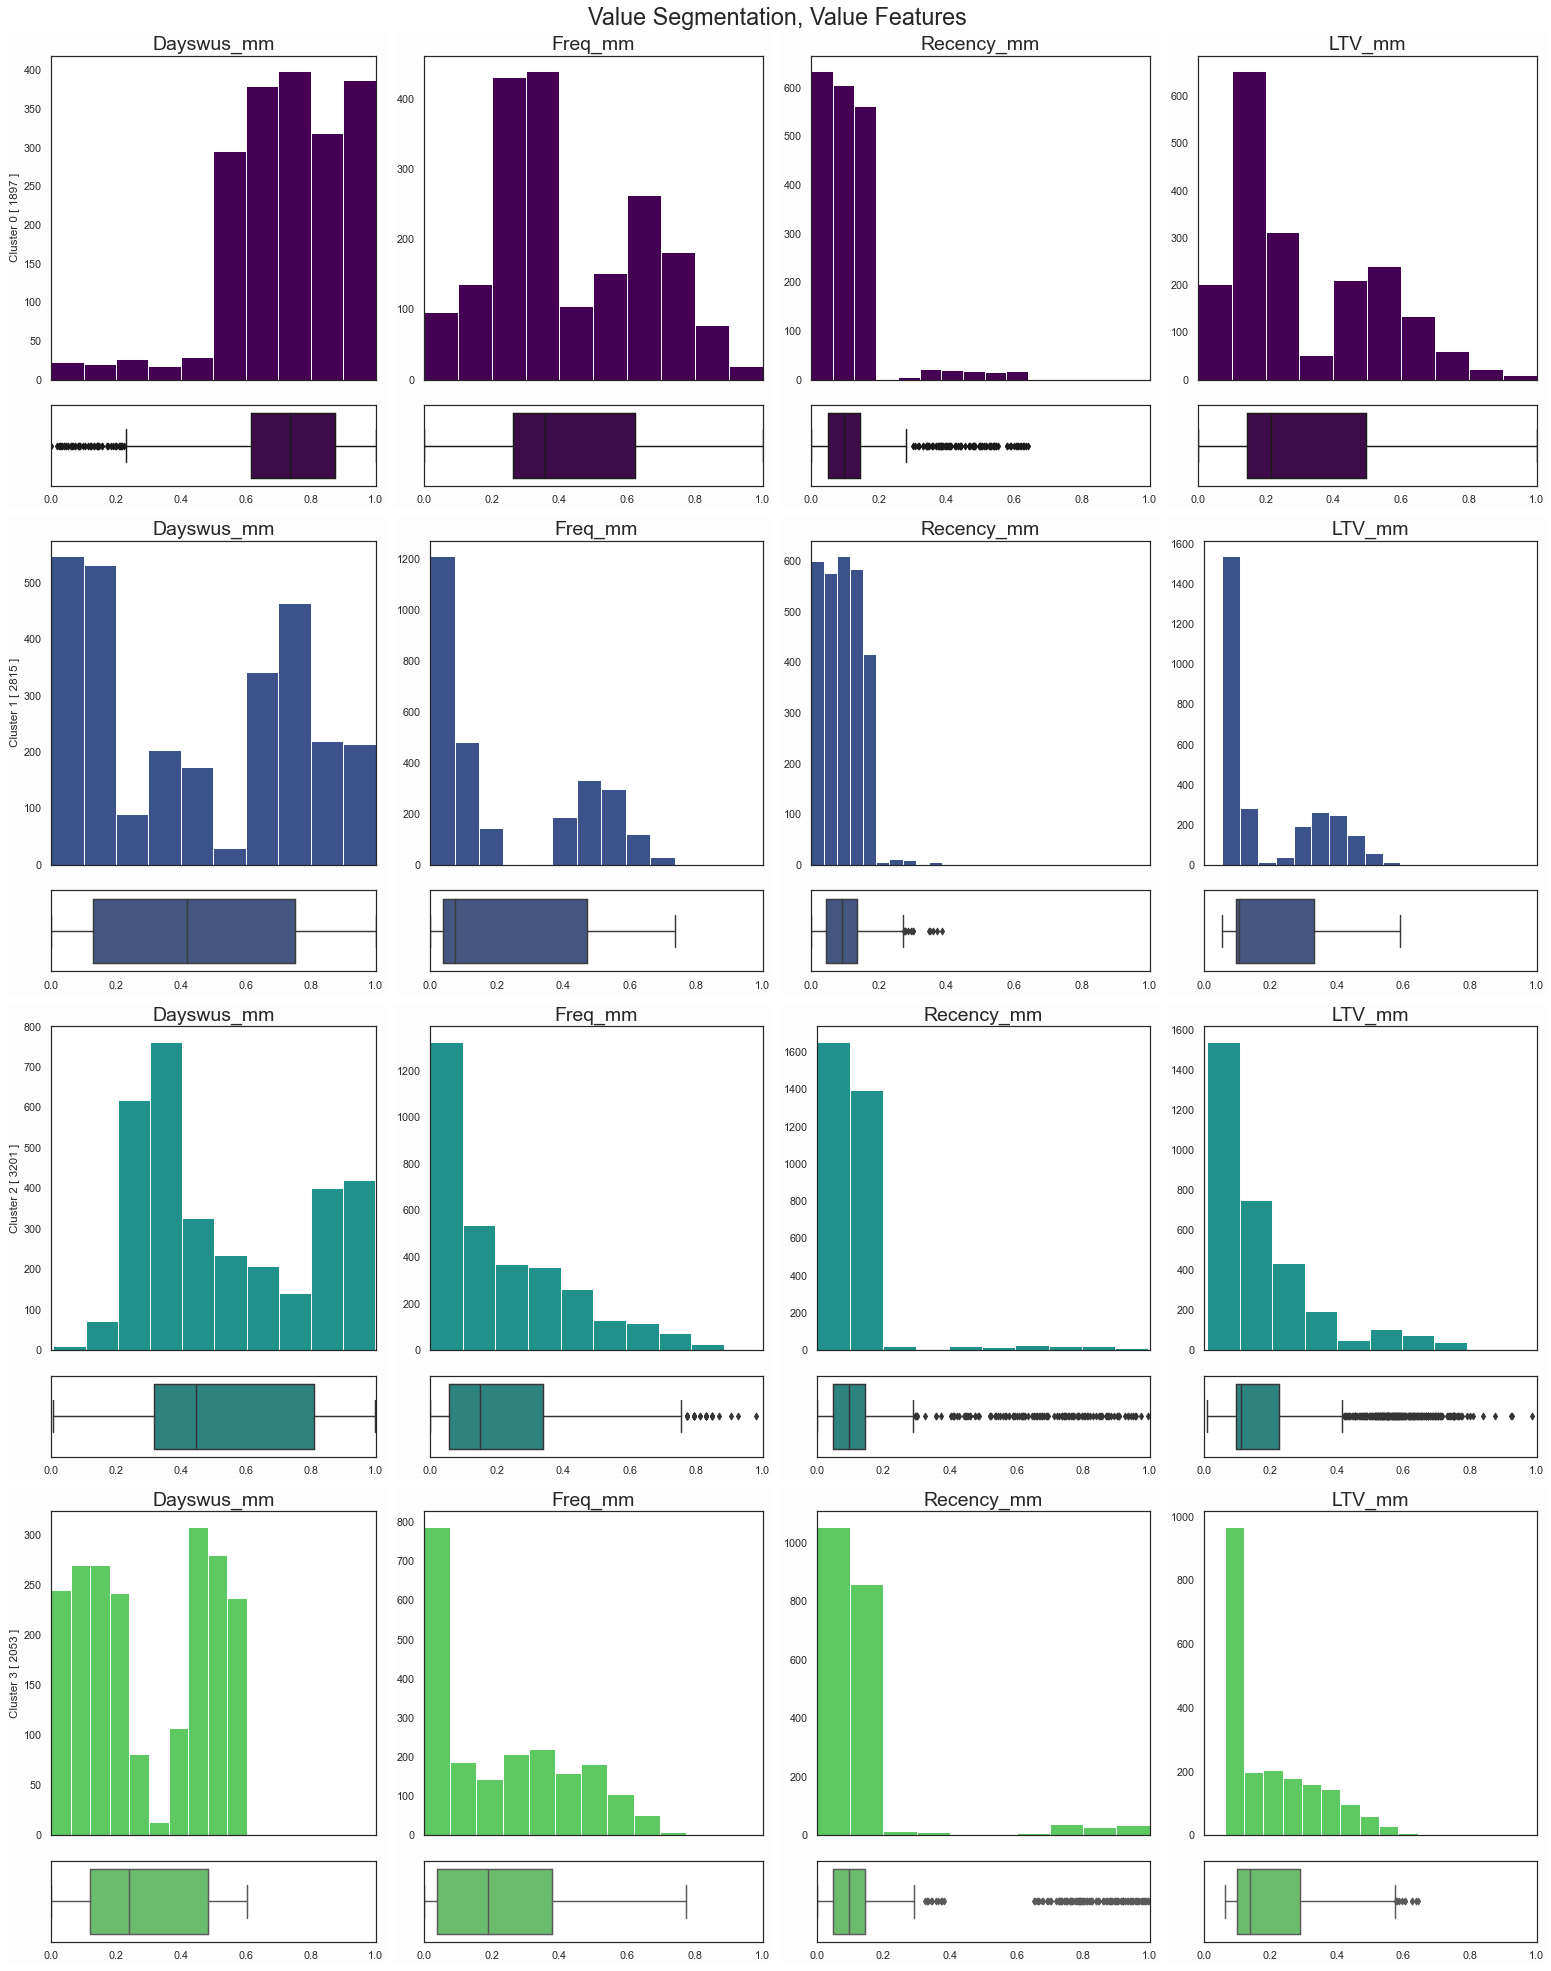

In [96]:
plot_final_histo_box(df_, wine_feats_dec, 'wine_labels', title='Wine Segmentation, Wine Features')
plot_final_histo_box(df_, value_feats_mm, 'value_labels', title='Value Segmentation, Value Features')

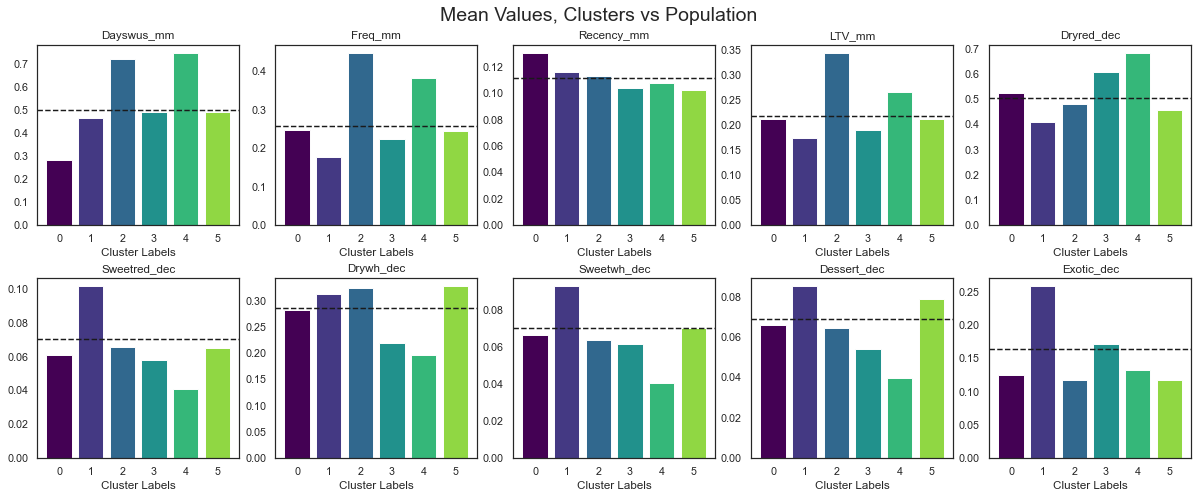

In [97]:
def hist_cluster_vs_all(df, k, col, feats, title='Mean Values, Clusters vs Population'):

    clustermeans_ = df.groupby(col).mean()[feats].reset_index()

    fig, axes = plt.subplots(2,int(len(feats)/2), figsize=(17,7), constrained_layout=True)
    i = 0
    
    colors = [ (cm.viridis(float(i) / len(clustermeans_['merged_labels']))) for i in range(len(clustermeans_['merged_labels'])) ]
    
    for m, ax in zip(feats, axes.flatten()):
        
        ax.bar(height=clustermeans_.loc[:,m], x=clustermeans_['merged_labels'].astype(str), color=colors)
        m_ = df[feats].mean()[m]
        ax.axhline(m_, label='Pop. mean', color='k',linestyle='dashed')
        ax.set_xlabel('Cluster Labels')
        if m == other_features[-1]:
            ax.legend(bbox_to_anchor=(.75,1.02), loc="upper right", frameon=False)
        ax.set_title(m)

    fig.suptitle(title, fontsize=20)

    save_fig(title, fig)

    plt.show()

hist_cluster_vs_all(df_,5,'merged_labels', vw_feats)



# Supporting Visualizations

In [98]:
## Code based from sklearn documentation:
## https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html?highlight=silhouette

def plotSilhouettes(X, max_clust, plot_dim, title = "Silhouette analysis for KMeans clustering with different K sizes"):
    range_n_clusters = range(2, max_clust+1)

    fig, axes = plt.subplots(plot_dim[0], plot_dim[1], sharex=True, figsize=(19,11))
    #fig.set_size_inches(11, 11)

    for ax, nclust in zip(axes.flatten(), range_n_clusters):
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, len(X) + (nclust + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=nclust, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        silhouette_avg = silhouette_score(X, cluster_labels)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(nclust):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.viridis(float(i) / nclust)
            #color = COLORS[i]
            ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=14)

        # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax.set_title("K = "+ str(nclust))
        #ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        
        plt.suptitle(
            title,
            fontsize=18,
            y=.95
        )
    save_fig(title, fig)
    plt.show()

## Ideal cluster sizes: silhouette plots

### Wine Segmentation

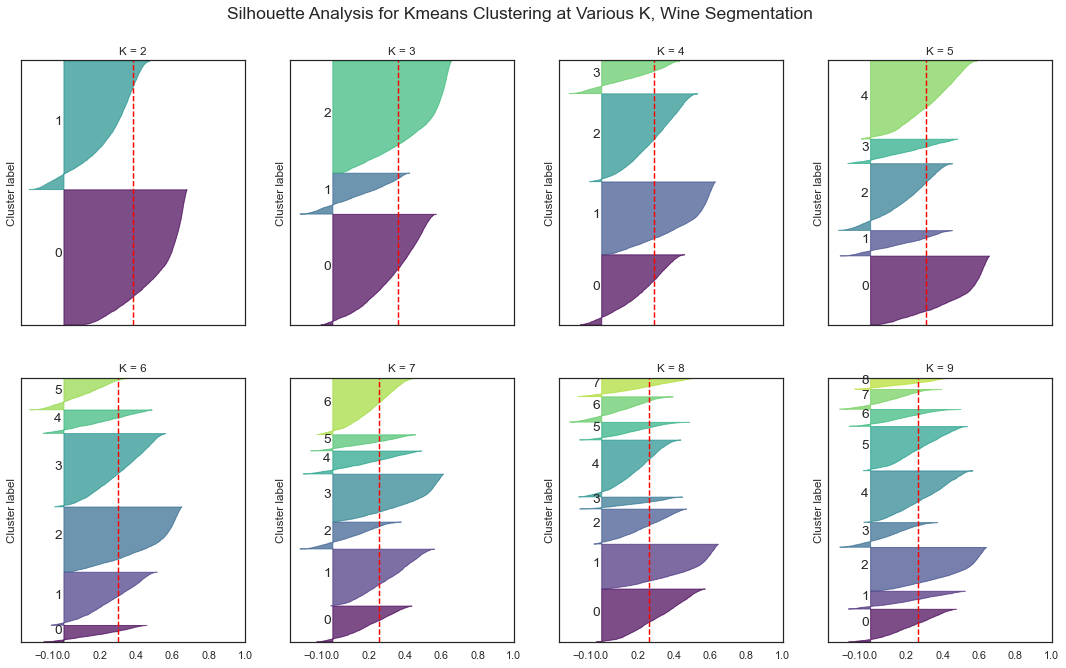

In [99]:
plotSilhouettes(df_wine_kmeans[wine_feats_dec], 9, [2,4], title='Silhouette Analysis for Kmeans Clustering at Various K, Wine Segmentation')

### Value Segmentation

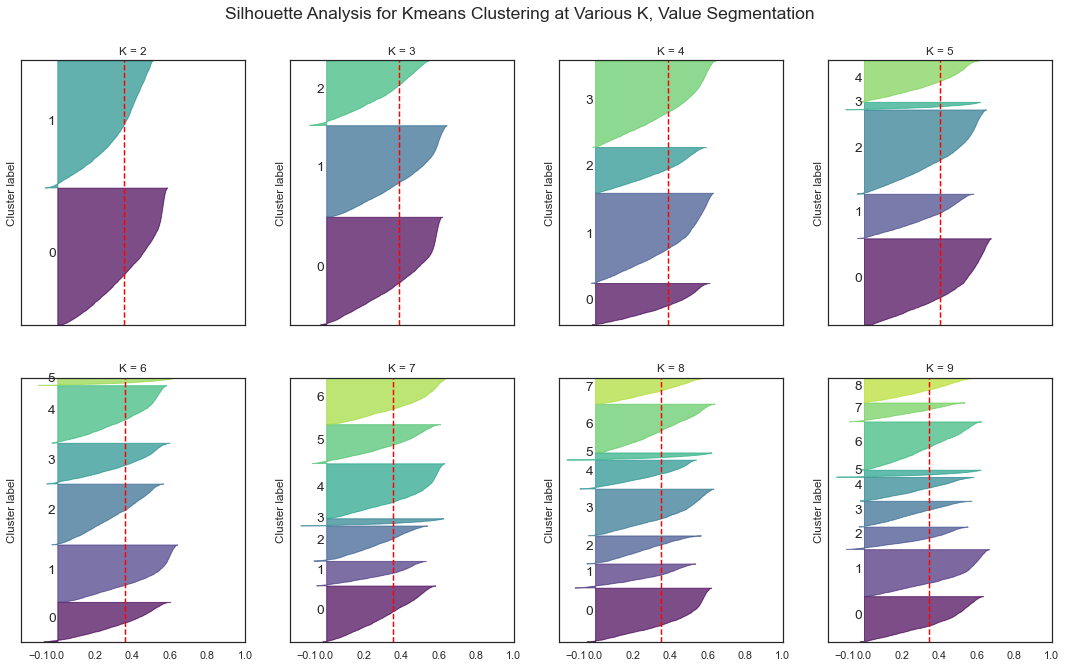

In [100]:
plotSilhouettes(df_value_kmeans[value_feats_mm], 9, [2,4], title='Silhouette Analysis for Kmeans Clustering at Various K, Value Segmentation')

# Other things we tried